### Reconstruction with application temperature parameters to scores

In [ ]:
# Ensure necessary packages are installed
!pip install cobra efmtool numpy pandas scipy

COBRApy Definition of the EV Network from Eberhard Voit's "A first course in Systems Biology"

In [1]:
from cobra import Model, Reaction, Metabolite

# Modell erstellen
model = Model("Toy_Network")

# Metaboliten definieren (intern)
A = Metabolite("A", compartment="c")
B = Metabolite("B", compartment="c")
C = Metabolite("C", compartment="c")
D = Metabolite("D", compartment="c")
E = Metabolite("E", compartment="c")

# Metaboliten definieren (extern)
A_e = Metabolite("A_e", compartment="e")
B_e = Metabolite("B_e", compartment="e")
D_e = Metabolite("D_e", compartment="e")
E_e = Metabolite("E_e", compartment="e")

# Reaktionen definieren
r1_in = Reaction("r1_in")
r1_in.name = "A import"
r1_in.lower_bound = 0
r1_in.upper_bound = 1000
r1_in.add_metabolites({A_e: -1, A: 1})

r2 = Reaction("r2")
r2.name = "A to C"
r2.lower_bound = 0
r2.upper_bound = 1000
r2.add_metabolites({A: -1, C: 1})

r3 = Reaction("r3")
r3.name = "C to D and E"
r3.lower_bound = 0
r3.upper_bound = 1000
r3.add_metabolites({C: -1, D: 1, E: 1})

r4_out = Reaction("r4_out")
r4_out.name = "D export"
r4_out.lower_bound = 0
r4_out.upper_bound = 1000
r4_out.add_metabolites({D: -1, D_e: 1})

r5 = Reaction("r5")
r5.name = "A to B"
r5.lower_bound = 0
r5.upper_bound = 1000
r5.add_metabolites({A: -1, B: 1})

r6r = Reaction("r6r")
r6r.name = "B to C"
r6r.lower_bound = -1000
r6r.upper_bound = 1000
r6r.add_metabolites({B: -1, C: 1})

r7 = Reaction("r7")
r7.name = "B to D"
r7.lower_bound = 0
r7.upper_bound = 1000
r7.add_metabolites({B: -1, D: 1})

r8r_out = Reaction("r8r_out")
r8r_out.name = "B import"
r8r_out.lower_bound = -1000
r8r_out.upper_bound = 1000
r8r_out.add_metabolites({B_e: -1, B: 1})

r9_out = Reaction("r9_out")
r9_out.name = "E export"
r9_out.lower_bound = 0
r9_out.upper_bound = 1000
r9_out.add_metabolites({E: -1, E_e: 1})

# Reaktionen zum Modell hinzufügen
model.add_reactions([r1_in, r2, r3, r4_out, r5, r6r, r7, r8r_out, r9_out])

# Modell überprüfen
print("Reaktionen:", [rxn.id for rxn in model.reactions])
print("Metaboliten:", [met.id for met in model.metabolites])
print("Gene:", [gene.id for gene in model.genes])

# Modell speichern (optional)
#model.save("toy_network.xml")


Reaktionen: ['r1_in', 'r2', 'r3', 'r4_out', 'r5', 'r6r', 'r7', 'r8r_out', 'r9_out']
Metaboliten: ['A_e', 'A', 'C', 'D', 'E', 'D_e', 'B', 'B_e', 'E_e']
Gene: []


In [2]:
import numpy as np
import cobra


def get_stoichiometric_matrix(model):
    # Filtere die Reaktionen, um nur Reaktionen zu behalten, die nicht mit "EX_" beginnen, also keine CobraPy-Exchange Reaktionen falls vorhanden
    internal_reactions = [rxn for rxn in model.reactions if not rxn.id.startswith("EX_")]

    # Extrahiere die Metaboliten aus dem Modell
    internal_metabolites = [meta for meta in model.metabolites if not meta.compartment == 'e']

    # Erstelle die leere Stöchiometrie-Matrix mit (Anzahl der Metaboliten, Anzahl der internen Reaktionen)
    stoichiometric_matrix = np.zeros((len(internal_metabolites), len(internal_reactions)))

    # Befülle die Stöchiometrie-Matrix so, dass jede Spalte eine Reaktion repräsentiert
    for j, rxn in enumerate(internal_reactions):  # Spaltenweise über Reaktionen iterieren
        for i, met in enumerate(internal_metabolites):  # Zeilenweise über Metaboliten iterieren
            stoichiometric_matrix[i, j] = rxn.metabolites.get(met, 0)  # Falls Metabolit nicht in der Reaktion ist, wird 0 zurückgegeben
    return stoichiometric_matrix

In [3]:
import efmtool
import cobra
import numpy as np
from efmtool import calculate_efms

def cobra_to_efms(model):
    # 1. Stoichiometric matrix (S matrix)
    metabolites = [
    metabolite for metabolite in model.metabolites 
    if metabolite.compartment == "c"
    ]
    reactions = model.reactions
    stoichiometry = np.zeros((len(metabolites), len(reactions)))
    #stoichiometry = get_stoichiometric_matrix(model)
    
    for i, met in enumerate(metabolites):
        for j, rxn in enumerate(reactions):
            try:
                stoichiometry[i, j] = rxn.get_coefficient(met.id)
            except KeyError:
                
                stoichiometry[i, j] = 0.0
    
    print("Stoichiometric matrix shape:", stoichiometry.shape)
    print("Stoichiometric matrix:", stoichiometry)

    # 2. Reversibilities: 1 for reversible, 0 for irreversible reactions
    reversibilities = [1 if rxn.reversibility else 0 for rxn in reactions]
    
    print("Reversibilities:", reversibilities)
    print("Number of reactions:", len(reactions))

    # 3. Reaction names
    reaction_names = [rxn.id for rxn in reactions]
    
    # 4. Metabolite names
    metabolite_names = [met.id for met in metabolites]
    
    return calculate_efms(stoichiometry, reversibilities, reaction_names, metabolite_names), reaction_names



# 6. Berechne die Elementarmoden (EFMs) mit dem efmtool und Reaktionsnamen
efms, reaction_names = cobra_to_efms(model)

# 7. Ergebnisse anzeigen
print("Berechnete Elementarmoden:")
print(np.column_stack((reaction_names, efms)))


Stoichiometric matrix shape: (5, 9)
Stoichiometric matrix: [[ 1. -1.  0.  0. -1.  0.  0.  0.  0.]
 [ 0.  1. -1.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1. -1.  0.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0. -1.]
 [ 0.  0.  0.  0.  1. -1. -1.  1.  0.]]
Reversibilities: [0, 0, 0, 0, 0, 1, 0, 1, 0]
Number of reactions: 9
2025-01-03  05:04:20.196  main                     INFO     | logger initialized
2025-01-03  05:04:20.197  main                     INFO     | =====================================================
2025-01-03  05:04:20.197  main                     INFO     | efmtool version 4.7.1, 2009-12-04 18:30:05
2025-01-03  05:04:20.198  main                     INFO     | Copyright (c) 2009, Marco Terzer, Zurich, Switzerland
2025-01-03  05:04:20.198  main                     INFO     | This is free software, !!! NO WARRANTY !!!
2025-01-03  05:04:20.198  main                     INFO     | See LICENCE.txt for redistribution conditions
2025-01-03  05:04:20.198  main                

Generate the datapoints using the Elementary FLux Modes. 
These will be called "experimental_data_zeropadded_out" from here on.

In [9]:
import numpy as np


input_array = np.column_stack((reaction_names, efms))

# Extract headers and values
headers = input_array[:, 0]
values = input_array[:, 1:].astype(float)  # Convert values to float

# Construct dictionaries
experimental_data = []
for col_idx in range(values.shape[1]):
    data_point = {}
    for row_idx, header in enumerate(headers):
        if header.endswith("_in") or header.endswith("_out"):
            # Add only reactions ending with "_in" or "_out"
            data_point[header] = values[row_idx, col_idx]
    # Normalize so "A_in" is always 1.0
    if "r1_in" in data_point and data_point["r1_in"] != 0.0:
        normalization_factor = data_point["r1_in"]
        for key in data_point.keys():
            data_point[key] /= normalization_factor
    else:
        if ("r8r_out" in data_point and data_point["r8r_out"] > 0):
            normalization_factor = data_point["r8r_out"]
            for key in data_point.keys():
                data_point[key] /= normalization_factor
        
    experimental_data.append(data_point)

# Output the result
for data in experimental_data:
    print(data)

experimental_data_zeropadded_out = experimental_data

{'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 0.0}
{'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}
{'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}
{'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 1.0}
{'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}
{'r1_in': 1.0, 'r4_out': 0.0, 'r8r_out': -1.0, 'r9_out': 0.0}
{'r1_in': 1.0, 'r4_out': 1.0, 'r8r_out': 0.0, 'r9_out': 0.0}
{'r1_in': 0.0, 'r4_out': 1.0, 'r8r_out': 1.0, 'r9_out': 1.0}


Create synthetic datapoint using sampling.

In [10]:
import cobra
from cobra.sampling import sample

import pandas as pd


# Function to normalize a row based on r1_in, excluding boundary reactions
def normalize_row(row, normalization_id):
    normalization_factor = row[normalization_id]
    # Exclude boundary reactions (columns starting with "EX_" or ending with "_out")
    filtered_row = {col: value for col, value in row.items() if (col.endswith("_in") or col.endswith("_out"))}
    return {col: (value / normalization_factor) if normalization_factor != 0 else 0.0
            for col, value in filtered_row.items()}


def create_synthetic_datapoints(model, amount, normalization_id):
    s = sample(model, amount)
    
    normalized_data = [normalize_row(row, normalization_id) for _, row in s.iterrows()]
    
    return normalized_data

For the sampling, exchange reactions have to be declared in CobraPy

Function to calculate scoring using Least Square Minimization.

Computes the sum of the distances of the closest solutions for each data datapoint. 

Return the Fit-score.

In [12]:
import numpy as np
from scipy.optimize import lsq_linear
from scipy.optimize import minimize





#print(reaction_ids)
# Funktion zur Ableitung des Zielvektors aus den experimentellen Daten
def create_target_vector(data_point, reaction_ids):
    target_flux = np.full(len(reaction_ids), np.nan)  # Vektor mit NaN initialisieren
    for rxn_id, value in data_point.items():
        if rxn_id in reaction_ids:  # Nur Reaktionen, die im Modell existieren
            idx = reaction_ids.index(rxn_id)
            target_flux[idx] = value  # Setze den Zielwert
    return target_flux


def least_square_min(model, S, experimental_data):
    reaction_ids = [rxn.id for rxn in model.reactions if not rxn.id.startswith("EX_")]
    total_score = 0.0
    successful_optimizations = 0

    for data_point in experimental_data:
        # Zielvektor für aktuellen Datenpunkt erstellen
        target_flux = create_target_vector(data_point, reaction_ids)

        # Filter für bekannte Flüsse (Reaktionen, die in 'target_flux' nicht NaN sind)
        known_flux_indices = ~np.isnan(target_flux)
        target_flux_values = target_flux[known_flux_indices]

        def objective(x):
            return np.linalg.norm(x[known_flux_indices] - target_flux_values)

        constraints = {'type': 'eq', 'fun': lambda x: np.dot(S, x)}

        initial_guess = np.zeros(len(reaction_ids))
        bounds = [(model.reactions.get_by_id(rxn_id).lower_bound,
                   model.reactions.get_by_id(rxn_id).upper_bound)
                  for rxn_id in reaction_ids]

        result = minimize(objective, initial_guess, constraints=constraints, bounds=bounds, tol=1e-10)

        if result.success:
            optimized_flux = result.x
            total_score += np.linalg.norm(optimized_flux[known_flux_indices] - target_flux_values)
            successful_optimizations += 1
        #else:
            #print(f"Optimization failed for data point: {data_point}. Message: {result.message}")

    # Return None if any optimization failed, otherwise the total score
    if successful_optimizations < len(experimental_data):
        return 0.0, len(experimental_data)
    else:
        return total_score, len(experimental_data)

 

S = get_stoichiometric_matrix(model)
print(least_square_min(model, S, experimental_data_zeropadded_out))

(3.123498217099662e-08, 8)


Function to generate random reactions using the internal metabolites of a model.

In [24]:
import random
from cobra import Reaction

# Erstellen von Reaktionen mit 1-2 Substrat(en) und 1-2 Produkt(en)
def generate_random_reactions(model, num_reactions=2000):
    # Filter out metabolites that end with '_EX'
    metabolites = [met for met in model.metabolites if not met.compartment == 'e']
    random_reactions = []

    for i in range(num_reactions):
        reaction_valid = False

        while not reaction_valid:
            # Zufällige Auswahl der Anzahl an Substraten und Produkten
            num_reactants = random.randint(1, 2)
            num_products = random.randint(1, 2)

            # Zufällige Auswahl der Substrate und Produkte
            reactants = random.sample(metabolites, num_reactants)
            products = random.sample(metabolites, num_products)

            # Check, dass auf beiden Seiten Metaboliten vorhanden sind
            if set(reactants).isdisjoint(set(products)):
                reaction_valid = True

                # Erstellung der Reaktion
                reaction = Reaction(f'Random_Rxn_{i+1}')
                reaction.name = f'Random Reaction {i+1}'

                reaction.add_metabolites({
                    met: -1.0 for met in reactants
                })
                reaction.add_metabolites({
                    met: 1.0 for met in products
                })

                # 50% Chance, die Reaktion reversibel zu machen
                if random.random() < 0.5:
                    reaction.lower_bound = -1000.0
                else:
                    reaction.lower_bound = 0.0

                reaction.upper_bound = 1000.0

                random_reactions.append(reaction)

    return random_reactions

# Generierung von 2000 zufälligen Reaktionen + den Inversen
random_reactions_list = generate_random_reactions(model, num_reactions=2000)

# Anzahl der insgesamt generierten Reaktionen
print(f"\nTotal number of random reactions generated: {len(random_reactions_list)}")


Total number of random reactions generated: 2000


Functions to sample reactions either from a model or from a list of reactions.

In [14]:
import cobra
import random

def sample_reactions(model, n_reactions):
    
    # Filter reactions that do not end with '_in' or '_out'
    valid_reactions = [rxn for rxn in model.reactions if not rxn.id.endswith('_in') and not rxn.id.endswith('_out')]

    # Ensure that the model has enough valid reactions
    if n_reactions > len(valid_reactions):
        raise ValueError("Requested number of reactions exceeds the total number of valid reactions in the model")

    # Sample reactions randomly from the valid reactions list
    sampled_reactions = random.sample(valid_reactions, n_reactions)

    for rxn in sampled_reactions:
        print(rxn.id)
    
    return sampled_reactions


In [15]:
import random

def sample_reactions_from_list(reactions_list, n_reactions):
    
    # Ensure the list has enough reactions to sample from
    if n_reactions > len(reactions_list):
        raise ValueError("Requested number of reactions exceeds the total number of reactions in the list")

    # Sample reactions randomly from the given list
    sampled_reactions = random.sample(reactions_list, n_reactions)

    for rxn in sampled_reactions:
        print(rxn.id if hasattr(rxn, 'id') else rxn)  # Print the ID if the object has one

    return sampled_reactions


Function to compute Edit distance between to models.

For instance the symmetric difference of the sets of reactions of two models.

In [16]:
def model_edit_distance(model1, model2):
    
    # Get sets of reaction IDs for both models
    reactions_model1 = {rxn.id for rxn in model1.reactions}
    reactions_model2 = {rxn.id for rxn in model2.reactions}
    
    # Calculate the symmetric difference (reactions present in one model but not the other)
    differing_reactions = reactions_model1.symmetric_difference(reactions_model2)
    
    # The edit distance is the number of differing reactions
    edit_distance = len(differing_reactions)
    
    return edit_distance



## Creating a scoring function that takes distance to input model into account

In [17]:
def score_combined(input_model, curr_model, S, experimental_data):
    model_score = model_edit_distance(input_model, curr_model)
    fit_score, num_evals = least_square_min(curr_model, S, experimental_data)
    if fit_score == 0.0:
        return None, None, num_evals
    score = (1 + fit_score) * model_score
    return score, fit_score, num_evals

## Evaluating the iterative addition of reaction after evaluating using a temperature parameter to create a probability distribution for the selection of reaction additions

In [18]:
# Temperature-softmax adjustment function
def temperature_softmax(scores, temperature=1.0):
    
    exp_scores = np.exp(np.array(scores) / temperature)
    return exp_scores / exp_scores.sum()

# Reaction selection function
def select_reaction(reactions, probabilities):
   
    return np.random.choice(reactions, p=probabilities)

In [19]:
# Reconstruction workflow
def reconstruct_model(input_model, original_model, reaction_list, experimental_data, threshold=3e-7, temperature=1.0):
    
    # Calculate Model Score for original model
    S = get_stoichiometric_matrix(original_model)
    original_score, _, _ = score_combined(input_model, original_model, S, experimental_data)

    print(original_score)
    
    # History to store reconstruction process
    history = []

    # Current model starts as input_model
    curr_model = input_model.copy()
    num_evals_total = 0
    while True:
        # Step 1: Compute scores for each reaction
        scores = []
        valid_reactions = []
        for reaction in reaction_list:
            test_model = curr_model.copy()
            test_model.add_reactions([reaction])
            S = get_stoichiometric_matrix(test_model)
            score, fit_score, num_evals = score_combined(input_model, test_model, S, experimental_data)
            if score is not None:
                scores.append(score)
                valid_reactions.append(reaction)
            num_evals_total += num_evals
        #print(scores)
        # Step 2: Flip scores such that lower scores have higher probabilities
        flipped_scores = [-np.log(score + 1e-10) for score in scores]
        
        # Step 3: Apply temperature adjustment
        probabilities = temperature_softmax(flipped_scores, temperature)
        #print(probabilities)
        # Step 4: Check if valid_reactions is empty
        if not valid_reactions:
            print("No valid reactions to consider. Stopping reconstruction.")
            return None, None, None

        # Select a reaction based on probabilities
        selected_reaction = select_reaction(valid_reactions, probabilities)
        #print(valid_reactions.index(selected_reaction))
        # Add the selected reaction to the model
        curr_model.add_reactions([selected_reaction])

        # Remove the reaction from the list
        reaction_list.remove(selected_reaction)

        # Compute the score after addition
        S = get_stoichiometric_matrix(curr_model)
        final_score, fit_score, num_evals = score_combined(input_model, curr_model, S, experimental_data)
        num_evals_total += num_evals

        # Record the history
        history.append({
            "reaction": selected_reaction.id,
            "final_score": final_score,
            "fit_score": fit_score,
            "num_evals": num_evals_total
        })

        # Check stopping condition
        if fit_score < threshold and fit_score != 0.0:
            print("Threshold reached. Reconstruction complete.")
            break
    
    
    
    return curr_model, history, original_score

In [20]:
def reduce_model_random(test_model, sampling_size):
    model = test_model.copy()
    reactions_to_remove = sample_reactions(model, sampling_size)
    removed_reactions = [model.reactions.get_by_id(reaction.id) for reaction in reactions_to_remove]
    model.remove_reactions(reactions_to_remove)
    random_reactions = generate_random_reactions(model, 50)
    random_reactions.extend(removed_reactions)
    return model, random_reactions

In [48]:
original_model = model.copy()
input_model, reaction_list = reduce_model_random(original_model, 2) # Input model with missing reactions

print(reaction_list)
S = get_stoichiometric_matrix(input_model)
fit_score, num_evals = least_square_min(input_model, S, experimental_data_zeropadded_out)
print(fit_score)

R3
R6
[<Reaction Random_Rxn_1 at 0x1768b8250>, <Reaction Random_Rxn_2 at 0x1768b82d0>, <Reaction Random_Rxn_3 at 0x1768851d0>, <Reaction Random_Rxn_4 at 0x1777c6b90>, <Reaction Random_Rxn_5 at 0x1768b83d0>, <Reaction Random_Rxn_6 at 0x176885890>, <Reaction Random_Rxn_7 at 0x176885e10>, <Reaction Random_Rxn_8 at 0x1768863d0>, <Reaction Random_Rxn_9 at 0x176886850>, <Reaction Random_Rxn_10 at 0x176886bd0>, <Reaction Random_Rxn_11 at 0x176886f50>, <Reaction Random_Rxn_12 at 0x176887390>, <Reaction Random_Rxn_13 at 0x176887810>, <Reaction Random_Rxn_14 at 0x176887c90>, <Reaction Random_Rxn_15 at 0x1768868d0>, <Reaction Random_Rxn_16 at 0x176887d10>, <Reaction Random_Rxn_17 at 0x17691ca50>, <Reaction Random_Rxn_18 at 0x17691ced0>, <Reaction Random_Rxn_19 at 0x17691d350>, <Reaction Random_Rxn_20 at 0x17691d7d0>, <Reaction R3 at 0x17689d7d0>, <Reaction R6 at 0x17689e810>]
Optimization failed for data point: {'A_in': 1.0, 'N_EX_out': 0.5, 'E_EX_out': 0.0, 'P_EX_out': 0.0, 'L_EX_out': 0.0, 'M_E

In [76]:
original_model = model.copy()
input_model, reaction_list = reduce_model_random(original_model, 2) # Input model with missing reactions



# Example scoring parameters and data



# Run reconstruction
temperature = 0.1
threshold = 3e-7

final_model, reconstruction_history, original_score = reconstruct_model(input_model, original_model, reaction_list, experimental_data_zeropadded_out, threshold, temperature)


R11
R5
2.000000141697168
[5.793921038945566, 14.553234651412545, 7.025545353409694, 11.622006931997625, 16.67504392264575, 16.67504392264574, 16.675043922652605, 16.675043922651604, 16.67504392265171, 14.553234650905415, 16.67504392265244, 16.675043922651795, 7.02554534216969, 16.67504392264555, 16.351607030414314, 16.675043922651987, 16.675043922644512, 16.675043922645685, 16.675043922652907, 16.675043922651817, 16.838989842155396, 16.675043922644534, 16.67504392264557, 17.755924149881665, 10.80724984230218, 7.950524952450065, 7.025545347863943, 16.675043922264553, 16.675043922645493, 15.906885091950606, 16.675043922652012, 16.67504392265286, 7.025545343342213, 16.675043922645422, 16.675043922644655, 16.675043922651938, 16.675043922645575, 16.67504392265289, 16.67504392265279, 13.70604383547129, 14.553234650910314, 16.67504392264574, 16.67504392265176, 16.675043922644605, 16.67504392265173, 7.0255453430873995, 16.67504392264461, 16.67504392264575, 16.67504392265173, 16.67504392265295,

In [64]:
# Display results
print("Reconstruction History:")
for step in reconstruction_history:
    print(step)

Reconstruction History:
{'reaction': 'Random_Rxn_3', 'final_score': 19.8096307123356, 'fit_score': 18.8096307123356, 'num_evals': 583}
{'reaction': 'Random_Rxn_16', 'final_score': 15.325146828817449, 'fit_score': 6.662573414408724, 'num_evals': 1155}
{'reaction': 'Random_Rxn_14', 'final_score': 21.820420331813146, 'fit_score': 6.273473443937715, 'num_evals': 1716}
{'reaction': 'Random_Rxn_44', 'final_score': 29.093897713505427, 'fit_score': 6.273474428376357, 'num_evals': 2266}
{'reaction': 'Random_Rxn_35', 'final_score': 28.90833401889192, 'fit_score': 4.781666803778384, 'num_evals': 2805}
{'reaction': 'Random_Rxn_7', 'final_score': 31.792281287671486, 'fit_score': 4.298713547945248, 'num_evals': 3333}
{'reaction': 'Random_Rxn_1', 'final_score': 18.89084284331201, 'fit_score': 1.6986918347588587, 'num_evals': 3850}
{'reaction': 'Random_Rxn_50', 'final_score': 21.58953464868302, 'fit_score': 1.6986918310853776, 'num_evals': 4356}
{'reaction': 'Random_Rxn_10', 'final_score': 24.28822641

In [21]:
def evaluate_model_singular(base_model, num_removed, temperatures, experimental_data, threshold=3e-7, seed = None):
 
    
    
    if seed is not None:
        np.random.seed(seed)
        
        
    results = {}

    # Create input model and random reaction pool
    original_model = base_model.copy()
    input_model, reaction_list = reduce_model_random(original_model, num_removed)
    print(reaction_list)
    for temperature in temperatures:
        print(f"Evaluating num_removed={num_removed}, temperature={temperature}")

        # Run reconstruction
        final_model, history, original_score = reconstruct_model(
            input_model, original_model, reaction_list, experimental_data, threshold, temperature
        )

        # Save results
        if final_model:
            results[temperature] = {
                "final_model": final_model,
                "history": history,
                "original_score": original_score
            }
        else:
            results[temperature] = {
                "final_model": None,
                "history": None,
                "original_score": None
            }

    return results


In [25]:
base_model = model.copy()
num_removed_list = [2, 3, 4]
temperatures = [0.1, 0.5, 1.0, 2.0, 5.0]
experimental_data = experimental_data_zeropadded_out
threshold = 3e-7
seeds = [13, 17, 21, 42, 100, 2023, 2025]  # seeds for reproducibility

final_scores = {temp: [] for temp in temperatures}

Example usage

R9
R4
R11
[<Reaction Random_Rxn_1 at 0x28e73de50>, <Reaction Random_Rxn_2 at 0x28e3c6c10>, <Reaction Random_Rxn_3 at 0x28e3c5450>, <Reaction Random_Rxn_4 at 0x1723c37d0>, <Reaction Random_Rxn_5 at 0x28e3c58d0>, <Reaction Random_Rxn_6 at 0x28e3c6ad0>, <Reaction Random_Rxn_7 at 0x28e3c4f50>, <Reaction Random_Rxn_8 at 0x28e3c6890>, <Reaction Random_Rxn_9 at 0x28e3c6250>, <Reaction Random_Rxn_10 at 0x28e3c7c50>, <Reaction Random_Rxn_11 at 0x28e3c75d0>, <Reaction Random_Rxn_12 at 0x28e3c7b10>, <Reaction Random_Rxn_13 at 0x28e3c7390>, <Reaction Random_Rxn_14 at 0x28e33b950>, <Reaction Random_Rxn_15 at 0x28af18850>, <Reaction Random_Rxn_16 at 0x28e33bc10>, <Reaction Random_Rxn_17 at 0x28e33a0d0>, <Reaction Random_Rxn_18 at 0x28e33b2d0>, <Reaction Random_Rxn_19 at 0x28e33b490>, <Reaction Random_Rxn_20 at 0x28e338f90>, <Reaction Random_Rxn_21 at 0x17220da90>, <Reaction Random_Rxn_22 at 0x28e33aad0>, <Reaction Random_Rxn_23 at 0x28e33acd0>, <Reaction Random_Rxn_24 at 0x28e338d10>, <Reaction Rand

[56.94687853410578, 47.16318962052526, 56.10415565990843, 47.163189620369955, 47.16318962035203, 34.677854955707815, 56.94687853410572, 47.16318962052537, 56.94687853410575, 47.16318962052532, 56.946878534105814, 47.16318962037043, 47.16318962052185, 56.94687853410572, 47.163189620503644, 56.94687853410573, 56.946878534105736, 51.706598030055275, 49.49818054598168, 47.16318962037334, 56.94687853410572, 56.94687853410573, 56.94687853410572, 47.16318962050118, 47.16318962034824, 47.163189620348064, 39.79376453512756, 47.16318962052168, 47.163189620522886, 24.054339048831583, 47.16318962035167, 47.1631896205042, 47.16318962052351, 47.16318962050394, 47.163189620526275, 47.16318962037025, 27.970767878248942, 56.94687853410572, 47.16318962034869, 47.16318962050392, 56.94687853410572, 50.21982402722814, 47.163189620522616, 47.16318962052288, 47.163189620522395, 51.706598030055275, 47.16318962052312, 56.94687853410572]
[0.02069018 0.02084147 0.0207011  0.02084147 0.02084147 0.02116212
 0.0206

[30.946658719550385, 32.83188720554095, 45.73379092494055, 23.613354058877576, 21.345737629743265, 45.875784235122616, 46.051088925727676, 28.101744664059964, 46.18784577483094, 45.733790924940905, 22.639579736655563, 30.045236481013152, 45.733790924963024, 45.777029431943184, 46.86147218219469, 49.38695813169336, 45.60694610967112, 45.11356044750296, 46.973041811516005, 45.73379092496293, 23.613354047319085, 45.73379092496283, 32.15822400633479, 45.733790924943904, 45.73379092494436, 42.11925864621273, 37.144474995459895, 34.52061784389873, 45.73379092494093, 17.02805989603365, 25.30560775975517, 47.24752820505047, 44.255150764294285, 45.73379092494109, 46.044085390593644, 54.020456263112536, 40.98634809309572, 45.73379092399685, 49.38695813169336, 23.61335405096467, 26.44344149452072]
[0.02450072 0.02445531 0.02424607 0.02474783 0.02485942 0.02424443
 0.02424242 0.02458101 0.02424086 0.02424607 0.02479295 0.02452449
 0.02424607 0.02424557 0.02423332 0.02420689 0.02424755 0.02425336
 

3.0000002125457526
[17.3801676561047, 17.380167586426126, 17.38016764660628, 19.8096307123356, 17.38016758425559, 19.8096307123356, 17.380167656923156, 17.380167601835655, 19.8096307123356, 19.8096307123356, 19.8096307123356, 16.67504392264577]
[0.08344733 0.08344733 0.08344733 0.08315343 0.08344733 0.08315343
 0.08344733 0.08344733 0.08315343 0.08315343 0.08315343 0.0835489 ]
9
[39.6192614246712, 33.350087845288925, 33.35008784529165, 33.35008784529116, 39.6192614246712, 39.6192614246712, 33.35008784528911, 39.6192614246712, 33.350087845291654, 39.6192614246712, 39.6192614246712, 34.297577577561654, 39.6192614246712, 39.6192614246712, 39.6192614246712, 33.350087845305715, 33.35008784529164, 33.35008784528897, 33.35008784529084, 33.35008784528907, 33.350087845291114, 33.35008784529106, 33.350087845291384, 33.35008784530577, 20.141615935560523, 39.6192614246712, 33.35008784528911, 39.6192614246712, 34.7603351676407, 33.35008784530383, 34.297577577561654, 33.35008784529113]
[0.03119313 0

[132.08001944393925, 132.08001944394883, 132.0800194439157, 132.0800194441516, 132.0800194438249, 55.0879505007983, 132.08001944414804, 132.08001944398873, 132.08001946066963, 131.33299688551492, 132.0800194439479, 115.1018165415421, 118.5796539570299, 88.20265688772264, 132.08001944439772, 88.20265682340428, 132.0800194437947, 85.48469259754685, 132.0800194457325, 132.08001944393385, 132.08001944399746, 12.000000968559329]
[0.04534991 0.04534991 0.04534991 0.04534991 0.04534991 0.04559049
 0.04534991 0.04534991 0.04534991 0.04535089 0.04534991 0.04537524
 0.04536946 0.0454354  0.04534991 0.0454354  0.04534991 0.04544358
 0.04534991 0.04534991 0.04534991 0.04710077]
15
[95.55287813260527, 95.55287825452791, 92.6084171172357, 95.55287825661787, 95.55287831645751, 59.67861307626693, 95.55287826987163, 95.55287826032557, 95.55287828012156, 95.55287823468419, 95.55287817038199, 95.55287819420452, 37.19647196672895, 95.55287827822833, 95.55287817426806, 94.7638506211171, 92.60841712928004, 

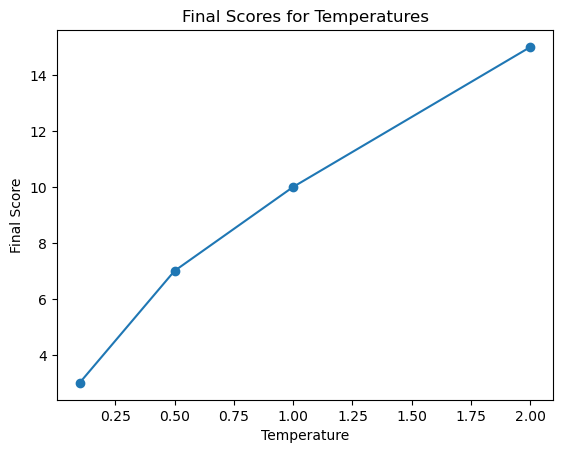

In [69]:
import matplotlib.pyplot as plt

results = evaluate_model_singular(base_model, num_removed, temperatures, experimental_data, threshold, 23)

# Extract final scores for the current seed
final_scores = []
for temp in temperatures:
    if results[temp]["history"]:  # Ensure history is not empty
        final_scores.append(results[temp]["history"][-1]['final_score'])
    else:
        print(f"Warning: No history for temperature {temp}")
        final_scores.append(None)  # Placeholder for missing data

# Filter out None values before plotting
filtered_temperatures = [t for t, score in zip(temperatures, final_scores) if score is not None]
filtered_scores = [score for score in final_scores if score is not None]

# Plot final scores for the current seed
plt.figure()
plt.plot(filtered_temperatures, filtered_scores, marker="o")
plt.xlabel("Temperature")
plt.ylabel("Final Score")
plt.title(f"Final Scores for Temperatures")
#plt.savefig(f"final_scores_seed_{seed}.png") 
plt.show()

In [53]:
results[0.1]['history']

[{'reaction': 'Random_Rxn_13',
  'final_score': 19.8096307123356,
  'fit_score': 18.8096307123356,
  'num_evals': 264},
 {'reaction': 'R5',
  'final_score': 32.38076908482351,
  'fit_score': 15.190384542411755,
  'num_evals': 517},
 {'reaction': 'Random_Rxn_18',
  'final_score': 48.57115352659155,
  'fit_score': 15.190384508863849,
  'num_evals': 759},
 {'reaction': 'Random_Rxn_10',
  'final_score': 4.0000002218842505,
  'fit_score': 5.547106267649217e-08,
  'num_evals': 990}]

r5
r2
[<Reaction Random_Rxn_1 at 0x28d48bad0>, <Reaction Random_Rxn_2 at 0x28ce87d10>, <Reaction Random_Rxn_3 at 0x28ce87a10>, <Reaction Random_Rxn_4 at 0x28ce84110>, <Reaction Random_Rxn_5 at 0x28ce86f10>, <Reaction Random_Rxn_6 at 0x28ce857d0>, <Reaction Random_Rxn_7 at 0x28ce84b90>, <Reaction Random_Rxn_8 at 0x28ce85650>, <Reaction Random_Rxn_9 at 0x28d51ebd0>, <Reaction Random_Rxn_10 at 0x28d48b750>, <Reaction Random_Rxn_11 at 0x28e18cb50>, <Reaction Random_Rxn_12 at 0x28d48aed0>, <Reaction Random_Rxn_13 at 0x28d489510>, <Reaction Random_Rxn_14 at 0x28d488490>, <Reaction Random_Rxn_15 at 0x28ce84d90>, <Reaction Random_Rxn_16 at 0x28ce86fd0>, <Reaction Random_Rxn_17 at 0x28d4f7590>, <Reaction Random_Rxn_18 at 0x28d4f7a10>, <Reaction Random_Rxn_19 at 0x28d489250>, <Reaction Random_Rxn_20 at 0x28ce86ed0>, <Reaction Random_Rxn_21 at 0x28d4f7dd0>, <Reaction Random_Rxn_22 at 0x28d4f6310>, <Reaction Random_Rxn_23 at 0x28d4f7310>, <Reaction Random_Rxn_24 at 0x28d4f5b50>, <Reaction Random_R

[1.0000000300726253, 8.601306265798808, 6.0472067268864755, 5.828427124778507, 4.604190281941161, 8.859905772959003, 8.859905765673414, 7.827852201100585, 8.727406619108905, 6.484633943165921, 8.727406621835911, 8.504260115593993, 8.85990577629612, 4.998683086001141, 7.552041766211284, 8.277916875175215, 4.99868309035082, 7.552041766206874, 1.0000000300726253, 7.609736646926723, 8.859905765678473, 4.182186510479047, 8.601306253088971, 5.828427129934265, 8.277916875352958, 8.859905776741044, 6.863703305282554, 6.484633943165921, 8.85990576567849, 8.859905765541008, 8.859905765673762, 8.727406614042412, 8.859905765673414, 6.484633943165921, 8.859905765664271, 5.828427129934265, 8.859905765673776, 1.0000000300726253, 8.277916875352958, 8.859905765678416, 6.484633943165921, 1.0000000276245606, 7.000000005845865, 4.182186552362262, 6.047206741337901, 8.727406622576785, 6.484633943165921, 1.0000000300726253]
[0.04757734 0.01622251 0.01934741 0.01970718 0.02217295 0.01598401
 0.01598401 0.017

[6.000000396497904, 16.192428120781056, 6.000000503301084, 6.000000412874796, 16.192431523372324, 22.970562800848263, 22.970562955672083, 6.000000849546388, 22.970562895258468, 12.623160834560768, 22.970562804133323, 22.970563008712297, 6.000000761252472, 6.000000659670931, 8.190890502180808, 15.071149492802974, 9.794733487743542, 8.190890502180808, 6.000000396497904, 18.39354688699924, 22.970563016200686, 16.192428219920856, 6.000000419990268, 15.071147585218666, 6.000000870174346, 22.970563012396415, 12.623160375043426, 22.97056344442569, 22.970563428221332, 22.970562955672083, 12.623160834560768, 6.000000419990268, 6.000000396497904, 15.071147585218666, 22.970563830527023, 12.623160834560768, 6.000000448929976, 15.071147535285435, 22.970563009509238, 6.0000004544111025, 22.970562846150788, 12.623160375043426]
[0.02730761 0.02238987 0.02730761 0.02730761 0.02238987 0.02087755
 0.02087755 0.02730761 0.02087755 0.02353317 0.02087755 0.02087755
 0.02730761 0.02730761 0.02565947 0.022713

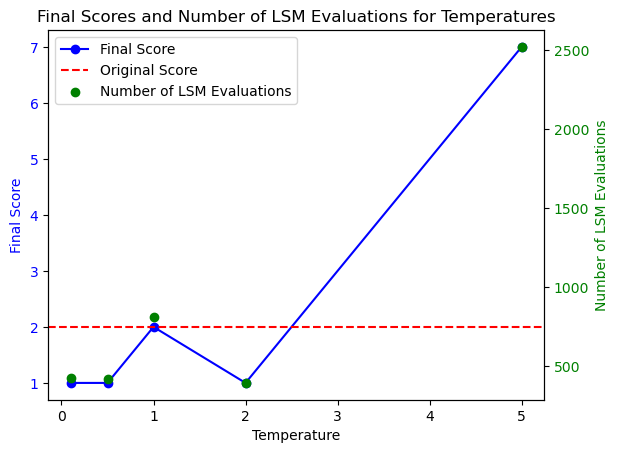

r6r
r3
r5
[<Reaction Random_Rxn_1 at 0x28d4ceb90>, <Reaction Random_Rxn_2 at 0x2925f06d0>, <Reaction Random_Rxn_3 at 0x28d1e8fd0>, <Reaction Random_Rxn_4 at 0x28c54a610>, <Reaction Random_Rxn_5 at 0x28c548790>, <Reaction Random_Rxn_6 at 0x28cf78610>, <Reaction Random_Rxn_7 at 0x28ce9d290>, <Reaction Random_Rxn_8 at 0x28cee7fd0>, <Reaction Random_Rxn_9 at 0x29254a5d0>, <Reaction Random_Rxn_10 at 0x28e29d9d0>, <Reaction Random_Rxn_11 at 0x28e6e47d0>, <Reaction Random_Rxn_12 at 0x28d1524d0>, <Reaction Random_Rxn_13 at 0x28d151f10>, <Reaction Random_Rxn_14 at 0x28d1536d0>, <Reaction Random_Rxn_15 at 0x28d153cd0>, <Reaction Random_Rxn_16 at 0x28d153650>, <Reaction Random_Rxn_17 at 0x28d152b50>, <Reaction Random_Rxn_18 at 0x28d075110>, <Reaction Random_Rxn_19 at 0x28d076090>, <Reaction Random_Rxn_20 at 0x28d075250>, <Reaction Random_Rxn_21 at 0x28d077610>, <Reaction Random_Rxn_22 at 0x28d150350>, <Reaction Random_Rxn_23 at 0x28d074610>, <Reaction Random_Rxn_24 at 0x28d076cd0>, <Reaction Rand

[4.000000214377406, 6.828427535646481, 4.000000222823583, 4.942809243342148, 6.828427219949395, 6.828427268712503, 6.828427319131581, 6.828427424994699, 6.828427623888289, 4.0000002485958275, 4.00000022851137, 4.0000001904287465, 4.000000183982882, 4.000000198483636, 6.828427202584438, 6.828427195206951, 6.828427298170933, 6.828427194367472, 6.828427268495492, 4.000000245099766, 6.828427238701758, 6.828427356857302, 6.828427424994699, 4.000000245099766, 6.82842730669079, 4.000000222545653, 6.828427258967627, 6.8284373613550695, 5.511858076202561, 5.511858055837505, 5.788854490936423, 6.828427334961955, 4.00000015829792, 6.8284272698958635, 5.511858058112743, 6.828427271921398, 5.5118580719142996, 6.828427561451344, 4.000000183982882, 6.828427334961955, 6.8284298514799175, 5.5118580364873555, 5.511858058112743, 6.8284273270411795, 5.511858111500827, 4.000000148032697, 6.828427627357993, 5.511858111500827]
[0.03714129 0.01274487 0.03714129 0.02432368 0.01274488 0.01274488
 0.01274488 0.0

[10.000000103290507, 4.000000215576677, 10.000000011823262, 10.000000053860735, 10.000000052229701, 10.000000074145346, 4.000000231527027, 10.000000106113916, 4.000000128749835, 10.000000046825026, 10.000000076410267, 10.00000007414483, 10.000000085542519, 10.00000005561736, 7.328201298375318, 10.000000090009271, 4.000000286950958, 10.00000003145405, 10.000000100912189, 4.000000231527027, 10.000000105169002, 4.0000001906166975, 10.000000112540468, 10.000000091769346, 10.000000097960418, 10.000000047969237, 10.000000077111897, 10.000000080559776, 10.000000076015947, 10.000000054173475, 10.000000103294665, 10.00000007414483, 10.000000080559776, 10.000000053176755, 10.000000037070665, 10.000000054173475, 7.328201244852966, 10.000000103893383, 4.000000145398735, 10.000000047432511, 10.000000103893383]
[0.02202435 0.03482356 0.02202435 0.02202435 0.02202435 0.02202435
 0.03482356 0.02202435 0.03482356 0.02202435 0.02202435 0.02202435
 0.02202435 0.02202435 0.02572791 0.02202435 0.03482356 0

[28.497833533533083, 25.807346607335635, 28.49783353354956, 22.712430286874635, 14.870349536532881, 28.49783353374628, 28.497833533546917, 16.317964664576365, 15.971370090134808, 28.32674102443505, 17.514867052399957, 28.497833533948377, 28.326740996870214, 14.870349536532881, 28.441830364075262, 17.514867052399957, 28.497833533890443, 22.71243028695097, 27.9060943290732, 27.90609433393323, 25.80734661975645, 28.49783353358493, 25.2156074071751, 21.93638104415212, 15.971370090134808, 22.494633953041152, 18.64799464174463, 27.906094305952458, 28.497833533950597, 27.90609433357162, 25.51278040576487, 22.712430282558216, 27.90609433357162]
[0.02916564 0.02974988 0.02916564 0.03051976 0.03321771 0.02916564
 0.02916564 0.03260624 0.03274654 0.02920079 0.03214789 0.02916564
 0.02920079 0.03321771 0.02917712 0.03214789 0.02916564 0.03051976
 0.02928829 0.02928829 0.02974988 0.02916564 0.02988822 0.03073271
 0.03274654 0.03057863 0.03174735 0.02928829 0.02916564 0.02928829
 0.02981826 0.030519

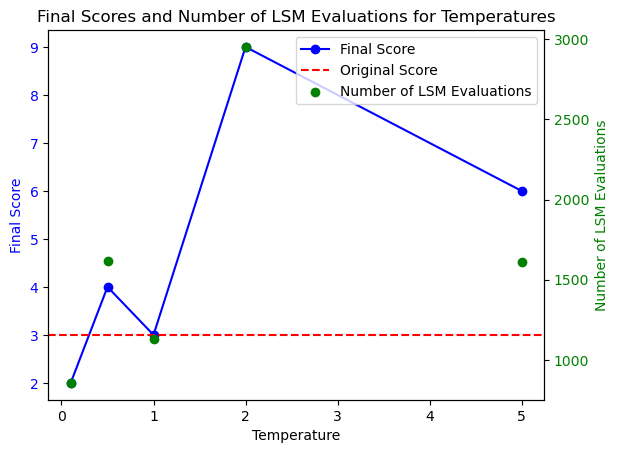

r7
r6r
r5
r2
[<Reaction Random_Rxn_1 at 0x28c8da610>, <Reaction Random_Rxn_2 at 0x28c8254d0>, <Reaction Random_Rxn_3 at 0x28c810890>, <Reaction Random_Rxn_4 at 0x28c609b10>, <Reaction Random_Rxn_5 at 0x28c886b90>, <Reaction Random_Rxn_6 at 0x28c8d0a50>, <Reaction Random_Rxn_7 at 0x28cf71c90>, <Reaction Random_Rxn_8 at 0x28c8bb210>, <Reaction Random_Rxn_9 at 0x28c818050>, <Reaction Random_Rxn_10 at 0x28d7ba810>, <Reaction Random_Rxn_11 at 0x28c8c4890>, <Reaction Random_Rxn_12 at 0x28c811dd0>, <Reaction Random_Rxn_13 at 0x28c81b890>, <Reaction Random_Rxn_14 at 0x28c812250>, <Reaction Random_Rxn_15 at 0x28c8d3910>, <Reaction Random_Rxn_16 at 0x28c812a50>, <Reaction Random_Rxn_17 at 0x28c812ed0>, <Reaction Random_Rxn_18 at 0x28c8135d0>, <Reaction Random_Rxn_19 at 0x28c8134d0>, <Reaction Random_Rxn_20 at 0x28c813b50>, <Reaction Random_Rxn_21 at 0x28c812f50>, <Reaction Random_Rxn_22 at 0x28c870590>, <Reaction Random_Rxn_23 at 0x28c813bd0>, <Reaction Random_Rxn_24 at 0x28c812850>, <Reaction R

[19.61780300888279, 14.1649658095906, 11.546559523773606, 19.617803001347216, 19.6178030090501, 11.546559514752346, 17.45481325228574, 19.61780300779819, 17.9700473054161, 13.827182723656128, 19.617803011406664, 16.313193056074248, 11.546559523773606, 17.454813231957395, 11.546559523773606, 19.61780300905003, 17.719811531346835, 18.019109095453437, 16.75394902685592, 19.617803011407, 18.019109100961483, 19.617803009050082, 19.617803009050004, 17.454813231957395, 14.164965809590573, 6.731379890499798, 6.731379890499798, 19.617803011406664, 16.753949026636008, 19.61780300888279, 19.617803009050082, 17.719811531346835, 19.082355494138067, 16.363223158516465, 17.97004730739338, 17.454813248766044, 17.970047309192182, 19.6178030090501, 19.617803008884533, 16.258784073949215, 19.61780300779819, 19.61780300781515, 18.019109095436235, 16.363223151122607, 6.731379890499798, 17.454813248766044, 19.617803011407, 19.617803011407, 17.719811531346835, 6.731379890499798]
[0.01040902 0.01996548 0.0300

[44.284271247461916, 30.01064697086604, 27.968593818935908, 38.62741700123835, 44.284271247461916, 44.284271247461916, 39.31370849900057, 35.94009461072446, 44.28427124746192, 29.845681146476938, 35.94009461478666, 37.48434334104243, 27.968593818935908, 35.313708501693, 27.968593818935908, 44.284271247461916, 38.62741700067018, 35.313708523594926, 31.41659285807845, 39.3137084989851, 44.28427124746192, 44.284271247461916, 35.313708501693, 30.01064697086604, 29.111667470369817, 29.111667470369817, 35.94009461478666, 34.33708193069626, 44.284271247461916, 27.968593819696423, 29.111667474625605, 41.25277219177777, 44.284271247461916, 44.28427124746192, 44.28427124746192, 35.94009461072446, 44.28427124746192, 37.443832565079944, 31.10195735558759, 29.111667470369817, 41.25277219177777, 44.28427124746191, 44.28427124746191, 38.62741700067018]
[0.0185631  0.02739205 0.02939201 0.0212816  0.0185631  0.0185631
 0.02091009 0.02287287 0.0185631  0.02754346 0.02287287 0.02193057
 0.02939201 0.023

[28.295363846410392, 16.914899968314028, 28.623533241329127, 28.62353324506102, 25.512780375896057, 28.623533245338766, 15.363961052084443, 20.412604677569263, 19.756265898484592, 16.914899963149193, 25.512780379416707, 28.29536384198356, 25.683872860914796, 24.32151481745922, 25.13092354028418, 28.623533241206797, 28.62353324120687, 25.512780379416707, 24.76968057173629, 10.09706979195904, 10.09706979195904, 28.623533251899225, 25.13092354041812, 28.295363846410392, 24.54483472642346, 25.341687855883535, 15.363961088714905, 28.623533241207305, 22.67099870128831, 28.623533245338766, 28.62353324268768, 24.321514814984035, 10.09706979195904, 25.341687855883535, 28.623533256609687, 28.623533256609687, 25.683872860914796]
[0.02407039 0.03113193 0.02393201 0.02393201 0.02534906 0.02393201
 0.03266549 0.02833946 0.02880636 0.03113193 0.02534906 0.02407039
 0.02526449 0.02596244 0.02554092 0.02393201 0.02393201 0.02534906
 0.02572649 0.04029425 0.04029425 0.02393201 0.02554092 0.02407039
 0.0

[12.745966865222647, 12.74596693896485, 12.745966845420877, 10.773502883700958, 5.000000166700213, 12.745966868390607, 5.000000210525904, 10.773502925212352, 12.071068201185142, 12.071068050930336, 5.000000210525904, 12.745966896290494, 5.000000264259976, 5.000000264259976, 5.000000260837925, 10.773503108041517, 12.745966856069684, 9.08248316349969, 12.745966975608232, 10.77350292338512, 10.773504446816425, 5.000000228150089, 12.745966845420877, 12.745967008162946, 8.162278303013908, 5.000000264259976, 12.745966859443092, 12.745966869421377]
[0.03333029 0.03333029 0.03333029 0.03447008 0.04019016 0.03333029
 0.04019016 0.03447008 0.03369493 0.03369493 0.04019016 0.03333029
 0.04019016 0.04019016 0.04019016 0.03447008 0.03333029 0.03566751
 0.03333029 0.03447008 0.03447008 0.04019016 0.03333029 0.03333029
 0.03643774 0.04019016 0.03333029 0.03333029]
17
[10.898979807573582, 10.89898579188872, 10.89897969411847, 6.000000392551034, 6.000000374953467, 10.89897980718081, 6.00000029439222, 6

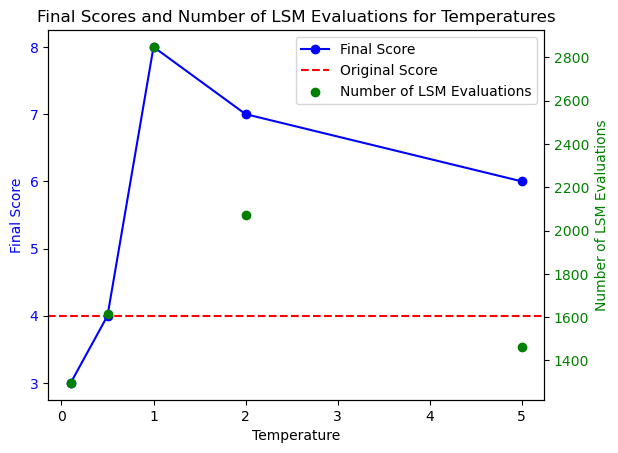

r7
r3
[<Reaction Random_Rxn_1 at 0x28ca56ed0>, <Reaction Random_Rxn_2 at 0x28c6f1750>, <Reaction Random_Rxn_3 at 0x28c9f40d0>, <Reaction Random_Rxn_4 at 0x28c8b9c90>, <Reaction Random_Rxn_5 at 0x28d1fe250>, <Reaction Random_Rxn_6 at 0x28e13dc90>, <Reaction Random_Rxn_7 at 0x29063fd50>, <Reaction Random_Rxn_8 at 0x290646d50>, <Reaction Random_Rxn_9 at 0x28e05a290>, <Reaction Random_Rxn_10 at 0x28e13c090>, <Reaction Random_Rxn_11 at 0x28e1207d0>, <Reaction Random_Rxn_12 at 0x28e120310>, <Reaction Random_Rxn_13 at 0x28e121b50>, <Reaction Random_Rxn_14 at 0x28c85ba50>, <Reaction Random_Rxn_15 at 0x28c85ba90>, <Reaction Random_Rxn_16 at 0x28e120290>, <Reaction Random_Rxn_17 at 0x28c85bad0>, <Reaction Random_Rxn_18 at 0x28cf7e110>, <Reaction Random_Rxn_19 at 0x28c858fd0>, <Reaction Random_Rxn_20 at 0x28c858e10>, <Reaction Random_Rxn_21 at 0x28c859ed0>, <Reaction Random_Rxn_22 at 0x28c85a190>, <Reaction Random_Rxn_23 at 0x28c858a10>, <Reaction Random_Rxn_24 at 0x28c8583d0>, <Reaction Random_R

[7.9024826981053815, 9.758031773833922, 9.758031773834134, 6.084234510983743, 5.465115221549706, 9.758031773833935, 9.177743010324365, 9.758031773831906, 8.304753469318833, 9.758031773831908, 8.7274066113382, 9.758031773847025, 5.280238967081215, 9.758031773833931, 9.758031773846927, 7.534145949075599, 8.304753469318811, 7.277916867664432, 5.465115221549706, 5.805883819655545, 9.177743010324365, 7.4960623646228814, 9.758031773846835, 7.534145949075562, 9.75803177384685, 9.758031773831917, 9.758031773849023, 8.974691495626319, 7.534145949129376, 9.758031775085453, 9.75803177383392, 9.758031773831917, 9.758031773833896, 8.727406610443168, 7.5341459491062714, 8.304753469318833, 9.758031773833999, 9.758031774443518, 8.7274066113382, 9.758031773831917, 4.000000019859474, 3.36568994203224, 9.758031773831943, 9.758031773831851, 7.277916868538457, 9.758031773833931, 4.000000019859474, 3.36568994203224]
[0.01995712 0.01616216 0.01616216 0.02592123 0.02885773 0.01616216
 0.01718405 0.01616216 0.

[35.00000004978397, 39.94337012565487, 5.0000002829924695, 5.000000386024428, 39.94337012923684, 39.94337012692984, 15.000000263225663, 39.94337013912135, 15.000000263225663, 39.94337013996629, 5.000000483841896, 5.000000352086471, 15.000000248322522, 35.00000008187036, 35.00000005473818, 19.082483072050636, 5.000000386024428, 15.000000296622407, 39.94337012692984, 35.00000007433048, 5.000000483841896, 35.00000005473818, 35.00000006845548, 39.94337012565924, 39.14213562616108, 35.000000049071026, 5.000000491778635, 39.94337012565615, 39.94337012566328, 35.00000010042352, 39.94337013912135, 35.00000000376381, 39.94337020355562, 39.14213570047745, 39.94337012565615, 7.041242064337121, 39.94337012565374, 39.94337012565633, 19.08248305532186, 33.28427126565613, 5.000000270778747, 7.041242064337121]
[0.01681648 0.01574152 0.04449221 0.04449221 0.01574152 0.01574152
 0.02568759 0.01574152 0.02568759 0.01574152 0.04449221 0.04449221
 0.02568759 0.01681648 0.01681648 0.02277464 0.04449221 0.02

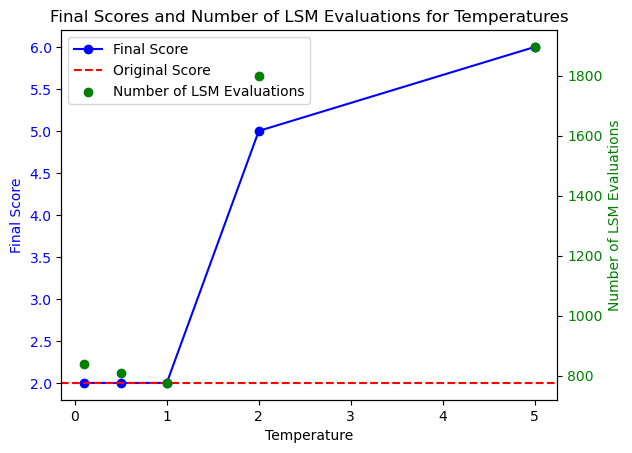

r5
r3
r6r
[<Reaction Random_Rxn_1 at 0x28e1dd010>, <Reaction Random_Rxn_2 at 0x28e69ae10>, <Reaction Random_Rxn_3 at 0x28ca6c850>, <Reaction Random_Rxn_4 at 0x28e6cf9d0>, <Reaction Random_Rxn_5 at 0x28e13b710>, <Reaction Random_Rxn_6 at 0x28e65a150>, <Reaction Random_Rxn_7 at 0x28e12fb90>, <Reaction Random_Rxn_8 at 0x28e698710>, <Reaction Random_Rxn_9 at 0x28e638110>, <Reaction Random_Rxn_10 at 0x28e6cefd0>, <Reaction Random_Rxn_11 at 0x28e639050>, <Reaction Random_Rxn_12 at 0x28e638e50>, <Reaction Random_Rxn_13 at 0x28e6394d0>, <Reaction Random_Rxn_14 at 0x28e6db3d0>, <Reaction Random_Rxn_15 at 0x28e639bd0>, <Reaction Random_Rxn_16 at 0x28e6db8d0>, <Reaction Random_Rxn_17 at 0x28e63a4d0>, <Reaction Random_Rxn_18 at 0x28e63aa50>, <Reaction Random_Rxn_19 at 0x28e63b450>, <Reaction Random_Rxn_20 at 0x28e63b250>, <Reaction Random_Rxn_21 at 0x28e63b9d0>, <Reaction Random_Rxn_22 at 0x28e63bd50>, <Reaction Random_Rxn_23 at 0x28e63bdd0>, <Reaction Random_Rxn_24 at 0x28e650b10>, <Reaction Rand

[9.940279654185206, 9.765208276611036, 10.440194532310166, 9.9103176046373, 10.440194532313708, 10.440194532314948, 10.256691113238448, 10.440194532310226, 10.440194532313708, 9.043409184100508, 10.046999431321641, 10.440194532310546, 6.464446424667184, 10.440194532309325, 10.440194532308897, 7.570810090951238, 10.440194532313713, 9.910317602720893, 5.669278968995426, 9.910317604637298, 7.570810090899819, 10.440194532309325, 8.727406618728317, 10.256691113238448, 9.910317602720893, 6.464446424667184, 6.449489758927767, 7.570810090899819, 10.440194532310498, 10.44019453231033, 10.440194532314727, 9.910317602720893, 10.440194532313708, 5.90577891787591, 4.000000013100254]
[0.02499649 0.02544463 0.02379957 0.02507206 0.02379957 0.02379957
 0.02422537 0.02379957 0.02379957 0.02747549 0.02473098 0.02379957
 0.03843672 0.02379957 0.02379957 0.03281975 0.02379957 0.02507206
 0.04382781 0.02507206 0.03281975 0.02379957 0.02847033 0.02422537
 0.02507206 0.03843672 0.03852586 0.03281975 0.023799

[9.940279654185206, 9.9103176046373, 10.440194532313708, 10.440194532314948, 10.256691113238448, 10.440194532310226, 10.440194532313708, 9.043409184100508, 10.046999431321641, 10.440194532310546, 10.440194532309325, 10.440194532308897, 7.570810090951238, 10.440194532313713, 9.910317602720893, 5.669278968995426, 9.910317604637298, 7.570810090899819, 10.440194532309325, 6.464446424667184, 6.449489758927767, 7.570810090899819, 10.440194532310498, 10.44019453231033, 10.440194532314727, 9.910317602720893, 10.440194532313708, 4.000000013100254]
[0.03502276 0.03504391 0.03468074 0.03468074 0.03480396 0.03468074
 0.03468074 0.0356914  0.03494804 0.03468074 0.03468074 0.03468074
 0.03698295 0.03468074 0.03504391 0.03918542 0.03504391 0.03698295
 0.03468074 0.03817014 0.03818783 0.03698295 0.03468074 0.03468074
 0.03468074 0.03504391 0.03468074 0.04201633]
24
[15.727406619420213, 19.820635209267074, 15.727406619420213, 20.51338222648334, 20.88038906462105, 9.913566380805355, 15.72740661054343, 1

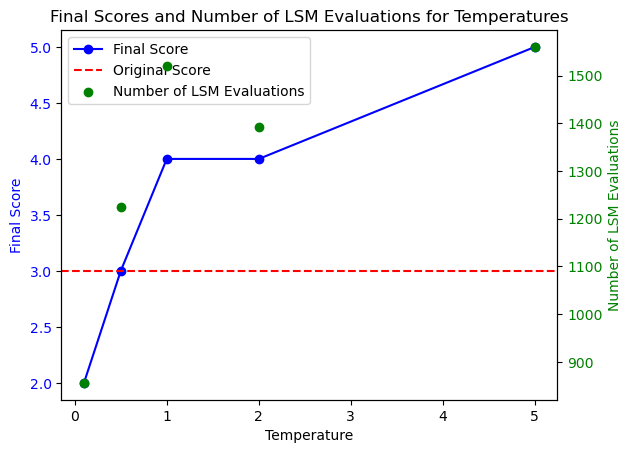

r2
r7
r5
r3
[<Reaction Random_Rxn_1 at 0x28afe1c90>, <Reaction Random_Rxn_2 at 0x28556fd50>, <Reaction Random_Rxn_3 at 0x2906c0c90>, <Reaction Random_Rxn_4 at 0x2906c0390>, <Reaction Random_Rxn_5 at 0x285504490>, <Reaction Random_Rxn_6 at 0x285434310>, <Reaction Random_Rxn_7 at 0x28aff0350>, <Reaction Random_Rxn_8 at 0x28ae4cc10>, <Reaction Random_Rxn_9 at 0x28543e590>, <Reaction Random_Rxn_10 at 0x28554f390>, <Reaction Random_Rxn_11 at 0x28543fcd0>, <Reaction Random_Rxn_12 at 0x28543ca50>, <Reaction Random_Rxn_13 at 0x28543c050>, <Reaction Random_Rxn_14 at 0x28543fc90>, <Reaction Random_Rxn_15 at 0x28543e510>, <Reaction Random_Rxn_16 at 0x28543e910>, <Reaction Random_Rxn_17 at 0x28543edd0>, <Reaction Random_Rxn_18 at 0x28543c490>, <Reaction Random_Rxn_19 at 0x285498810>, <Reaction Random_Rxn_20 at 0x285499490>, <Reaction Random_Rxn_21 at 0x285498090>, <Reaction Random_Rxn_22 at 0x285499050>, <Reaction Random_Rxn_23 at 0x285499990>, <Reaction Random_Rxn_24 at 0x28549a690>, <Reaction Ra

[19.950521673332677, 18.08681836818033, 20.301800427473594, 20.301800427473584, 17.454813220734614, 15.727406611473864, 19.655129474778278, 19.080871506492784, 19.063561848545092, 17.258568129726292, 12.692130440280181, 17.942388669664577, 19.51579613964562, 20.301800427473587, 19.65512947482787, 20.301800427473594, 10.930230445405357, 19.247964164962227, 13.262111038327268, 19.080871506492784, 13.04340919553128, 19.080871506440197, 19.655129474823628, 17.258568129726292, 19.95052167330668, 15.727406611473864, 13.04340922508187, 13.04340919553128, 20.301800427473587, 18.396219444925727, 20.301800427473584, 19.0635618485441, 20.301800427473577, 14.099770536685721, 20.301800427473577, 20.301800427473584, 15.727406612978516, 18.396219444925723, 17.942388669648537, 17.258568129490303, 20.029212606760595, 13.043409205835744, 20.301800427473584, 19.080871506492784, 15.727406610321498, 18.08681836929888, 12.168469024333849, 18.08681836929888, 12.1684690202527, 16.920615481584974]
[0.01411603 

[22.142135623732788, 22.142135623732784, 22.14213562373278, 19.65685424949238, 17.656854254073103, 17.45481322073744, 17.97004731462259, 22.14213562373276, 14.176896387391984, 14.82842714401569, 14.555833740104557, 14.17689640223583, 22.142135623732788, 19.656854249594748, 22.142135623732727, 14.555833739540104, 14.17689640497726, 17.97004731462259, 14.555833736328102, 17.970047309192015, 19.65685424975122, 22.14213562373279, 17.656854254073103, 14.555833737497919, 14.555833736328102, 22.14213562373277, 22.142135623732756, 22.142135623736603, 16.6263860959546, 22.142135623732766, 22.142135623736603, 17.656854263983348, 22.142135623732777, 20.485281374253162, 14.176896376574444, 17.970047313863056, 22.142135623732756, 17.97004731462259, 14.828427145751936, 19.313708503529583, 14.555833739540104, 19.313708503529583, 14.55583373535582, 17.970047305528873]
[0.01838554 0.01838554 0.01838554 0.02071008 0.02305592 0.02332279
 0.02265409 0.01838554 0.02871538 0.02745369 0.02796783 0.02871538
 

[41.806232149502634, 41.806232215549734, 20.000000178703424, 29.456949873248746, 21.113618526050857, 36.38958434855776, 35.46869535937646, 29.029418664067904, 41.80623214818776, 40.44329304325066, 41.80623215727642, 40.72844725119268, 41.80623215699022, 36.389584345815365, 24.234500989878846, 21.113618526053113, 41.806232148203684, 21.113618567906865, 40.728449983808105, 41.80624369596608, 20.000000178703424, 41.806232148203684, 41.80623215273016, 30.940758904367648, 40.72844747285962, 41.806232156924864, 41.806232153294616, 20.00000302549036, 30.940758903825095, 41.8062321946067, 35.46869535017802, 35.4686953474767, 21.113618526050857, 40.049838474010215, 20.000000111676112, 41.80623214750291, 14.309036757182632]
[0.02345812 0.02345812 0.03391554 0.02794601 0.033009   0.02514347
 0.02546778 0.02815105 0.02345812 0.02385011 0.02345812 0.02376648
 0.02345812 0.02514347 0.03081035 0.033009   0.02345812 0.033009
 0.02376648 0.02345812 0.03391554 0.02345812 0.02345812 0.02726768
 0.0237664

[36.13163034316844, 29.730952813159455, 29.022703842556304, 22.602437850957156, 19.712430268187067, 36.13163034316832, 36.13163034316843, 19.712430263321426, 17.56715058878302, 29.73095280013417, 36.13163034316843, 29.730952813159455, 26.350431747792978, 36.13163034316846, 29.730952801944234, 36.13163034316823, 36.13163034316843, 36.13163034316096, 29.730952813159455, 22.602437844657565, 26.955070980223326]
[0.04549862 0.04730794 0.04753661 0.04997407 0.05136032 0.04549862
 0.04549862 0.05136032 0.0525576  0.04730794 0.04549862 0.04730794
 0.04846388 0.04549862 0.04730794 0.04549862 0.04549862 0.04549862
 0.04730794 0.04997407 0.04824448]
3
[30.13658380127623, 30.138645777349062, 10.000000061695687, 28.898979539521086, 30.136583801276338, 14.82842718924439, 30.136583801284743, 30.136583801284914, 14.828427173813852, 16.89089482574809, 10.000000056949826, 30.136583801285003, 10.000000061695687, 31.315584847271946, 28.0000000382736, 30.13673441804211, 30.136583801276213, 10.0000000499780

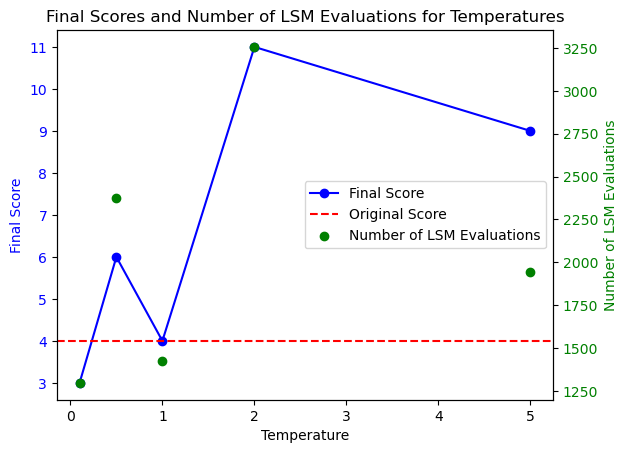

r6r
r2
[<Reaction Random_Rxn_1 at 0x28cee6050>, <Reaction Random_Rxn_2 at 0x28c78ba50>, <Reaction Random_Rxn_3 at 0x28d1240d0>, <Reaction Random_Rxn_4 at 0x28d124a50>, <Reaction Random_Rxn_5 at 0x28cb51fd0>, <Reaction Random_Rxn_6 at 0x28e4be450>, <Reaction Random_Rxn_7 at 0x285560290>, <Reaction Random_Rxn_8 at 0x28e5dd410>, <Reaction Random_Rxn_9 at 0x28e4bf990>, <Reaction Random_Rxn_10 at 0x28e4bda90>, <Reaction Random_Rxn_11 at 0x28e4bd010>, <Reaction Random_Rxn_12 at 0x28e4be590>, <Reaction Random_Rxn_13 at 0x28e4be810>, <Reaction Random_Rxn_14 at 0x28e4bd490>, <Reaction Random_Rxn_15 at 0x28e4befd0>, <Reaction Random_Rxn_16 at 0x28e4bd910>, <Reaction Random_Rxn_17 at 0x28e4bce90>, <Reaction Random_Rxn_18 at 0x28e4bf250>, <Reaction Random_Rxn_19 at 0x28e4bc950>, <Reaction Random_Rxn_20 at 0x28e07e190>, <Reaction Random_Rxn_21 at 0x28d127850>, <Reaction Random_Rxn_22 at 0x28d125210>, <Reaction Random_Rxn_23 at 0x28e4bc890>, <Reaction Random_Rxn_24 at 0x28d787590>, <Reaction Random_

[5.32379020435563, 5.32379011769364, 5.323790102972199, 5.3237905083004415, 5.323790149636852, 3.000000132317406, 5.323790043985019, 5.121320526915558, 5.323790251655367, 5.323790398789278, 3.7071068589229923, 5.323790398761632, 5.323790118627764, 3.0000001367873894, 3.0000001395823443, 4.1338935720648085, 3.00000009677909, 4.133893544743717, 3.000000098911749, 5.323790149790304, 3.0000001132810565, 3.0000001104801806, 5.323790402276456, 4.73205099852441, 3.7071068903447744, 3.0000001473325235, 4.133893544743717, 5.3237900971644265, 5.323790398773915, 3.0000000780797786, 3.0000001367873894, 3.0000001132810565, 4.13389361644525, 5.323790183911073, 4.000000208873098, 5.323790382498368, 3.0000001367873894, 5.121320446055695, 5.323790398783045, 5.121320513509534, 5.323790311280282, 3.0000001367873903, 3.0000001435404315, 3.0000001373825587, 5.32379039878, 3.0000001367873894, 5.323790121338356]
[0.01613119 0.01613119 0.01613119 0.01613119 0.01613119 0.02862635
 0.01613119 0.01676893 0.01613

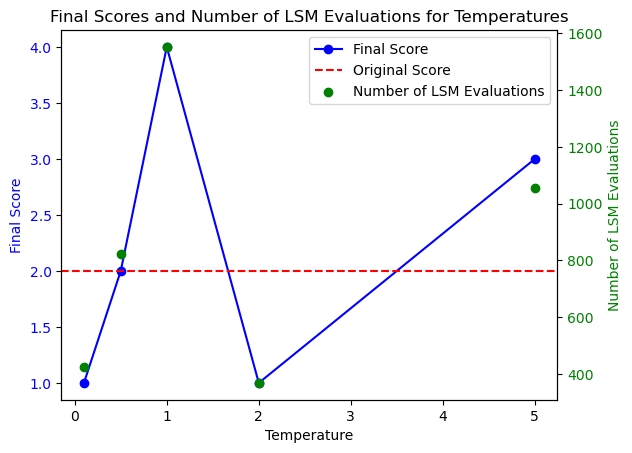

r6r
r2
r5
[<Reaction Random_Rxn_1 at 0x285490fd0>, <Reaction Random_Rxn_2 at 0x28e6f24d0>, <Reaction Random_Rxn_3 at 0x28e68dc50>, <Reaction Random_Rxn_4 at 0x28c9ff250>, <Reaction Random_Rxn_5 at 0x28e6d9910>, <Reaction Random_Rxn_6 at 0x28e6d9850>, <Reaction Random_Rxn_7 at 0x28d0db710>, <Reaction Random_Rxn_8 at 0x28e6daa10>, <Reaction Random_Rxn_9 at 0x28e6db490>, <Reaction Random_Rxn_10 at 0x28e6db5d0>, <Reaction Random_Rxn_11 at 0x28e6d8050>, <Reaction Random_Rxn_12 at 0x28e658dd0>, <Reaction Random_Rxn_13 at 0x28e658f90>, <Reaction Random_Rxn_14 at 0x28e6d9b10>, <Reaction Random_Rxn_15 at 0x28e659250>, <Reaction Random_Rxn_16 at 0x28e659ad0>, <Reaction Random_Rxn_17 at 0x28e6d8350>, <Reaction Random_Rxn_18 at 0x28c9fd990>, <Reaction Random_Rxn_19 at 0x28e6dbf50>, <Reaction Random_Rxn_20 at 0x28e695dd0>, <Reaction Random_Rxn_21 at 0x28e623390>, <Reaction Random_Rxn_22 at 0x28e620d10>, <Reaction Random_Rxn_23 at 0x28e6dd750>, <Reaction Random_Rxn_24 at 0x28e19a290>, <Reaction Rand

[16.22978949194447, 22.71243027290475, 22.712430272867376, 20.591109955959247, 7.500000041286299, 22.712430272859624, 22.712430269704306, 20.591109972287548, 22.712430272856917, 15.049523605279212, 20.591109972288095, 15.049523574045747, 22.71243025981201, 22.09110992343268, 16.71243030051938, 13.606601819357081, 21.360010276370897, 21.539793226034202, 13.606601792321646, 17.396794234677575, 22.712430272857773, 22.71243025981201, 22.712430272858317, 14.428203242057958, 13.606601777673365, 22.712430259223467, 22.71243027287155, 19.238689945866547, 15.363961101419036, 20.591109972288095, 22.712430272857034, 16.712430297925724, 13.606601754617555, 20.848469228744634, 17.485281374469526, 22.712430259223467, 22.712430272858064, 16.712430332873538, 19.238689946068583, 8.121320390728233, 22.712430272857034, 20.428203243925278, 22.71243025981201, 22.09110992938611, 20.173031308342217, 22.712430259365682, 20.591109955965067, 16.71243027602779, 8.121320429511897]
[0.02132576 0.01088938 0.0108893

[6.088932060009857, 6.000000136270552, 6.088931963783837, 4.000000111843099, 6.088932046496436, 6.000000170810927, 4.00000020854248, 6.088932024596781, 4.00000020854248, 6.088932103209105, 6.088932344079327, 5.154700671570144, 6.065591346348349, 6.0889320771199635, 4.000000196447065, 6.088932064718126, 6.088931978565473, 6.088932344079327, 5.788854543746502, 4.000000200750196, 6.0655912852063505, 6.088932024149345, 5.788855690528315, 4.000000150799228, 5.154700684909209, 4.00000020854248, 4.000000120589361, 4.000000173482832, 5.333333432625742, 6.088932024149345, 6.088931996496564, 5.15470074818342, 5.333333765312258, 6.088932047761576, 6.088931981091638, 6.000000274466959, 6.088932344079327, 4.000000246009812, 4.00000018061554, 6.088932014934782, 4.000000176213124, 6.08893202613081, 6.088932005941594]
[0.01990062 0.02019558 0.01990062 0.03029338 0.01990062 0.02019558
 0.03029338 0.01990062 0.03029338 0.01990062 0.01990062 0.02350738
 0.0199772  0.01990062 0.03029338 0.01990062 0.01990

[18.041452004008683, 7.000000644962311, 18.041453248121083, 18.041451992177826, 7.000000451073246, 7.000000542155501, 7.000000542155499, 18.041452038329624, 7.000000271470441, 7.000000430819787, 18.04145219346974, 7.000000595668364, 18.04145244933253, 7.0000004646403085, 18.041452038329624, 7.000000337442444, 18.041452447484456, 7.0000005192132315, 7.000000489953892, 7.000000585531722, 7.00000048411368, 7.000000542155499, 7.000000839352945, 7.000000445622399, 7.000000388809757, 7.000000489953892, 7.000000414629826, 7.0000004692189215, 18.04145213344002, 18.041452233538152, 18.041465179877825, 7.0000004493385095, 18.041452116515952, 7.0000004559941775, 7.000000445843812, 18.041453912660575]
[0.02003025 0.03215682 0.02003025 0.02003025 0.03215682 0.03215682
 0.03215682 0.02003025 0.03215682 0.03215682 0.02003025 0.03215682
 0.02003025 0.03215682 0.02003025 0.03215682 0.02003025 0.03215682
 0.03215682 0.03215682 0.03215682 0.03215682 0.03215682 0.03215682
 0.03215682 0.03215682 0.03215682

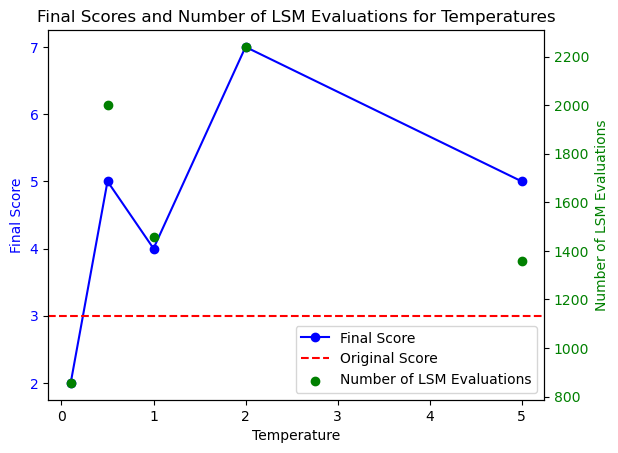

r2
r5
r7
r3
[<Reaction Random_Rxn_1 at 0x28e12f790>, <Reaction Random_Rxn_2 at 0x28aa54c10>, <Reaction Random_Rxn_3 at 0x29063ea50>, <Reaction Random_Rxn_4 at 0x28d528350>, <Reaction Random_Rxn_5 at 0x28aa34090>, <Reaction Random_Rxn_6 at 0x28aa34a90>, <Reaction Random_Rxn_7 at 0x28e12f010>, <Reaction Random_Rxn_8 at 0x28e423050>, <Reaction Random_Rxn_9 at 0x28e420750>, <Reaction Random_Rxn_10 at 0x28aa34750>, <Reaction Random_Rxn_11 at 0x28e421bd0>, <Reaction Random_Rxn_12 at 0x28e029790>, <Reaction Random_Rxn_13 at 0x28e02b490>, <Reaction Random_Rxn_14 at 0x28e02b410>, <Reaction Random_Rxn_15 at 0x28cc83b50>, <Reaction Random_Rxn_16 at 0x28e029290>, <Reaction Random_Rxn_17 at 0x28e028bd0>, <Reaction Random_Rxn_18 at 0x28e029850>, <Reaction Random_Rxn_19 at 0x28e028350>, <Reaction Random_Rxn_20 at 0x28e02a310>, <Reaction Random_Rxn_21 at 0x28e028a10>, <Reaction Random_Rxn_22 at 0x28e02bb90>, <Reaction Random_Rxn_23 at 0x28e0286d0>, <Reaction Random_Rxn_24 at 0x28d151490>, <Reaction Ra

[26.534440469144215, 26.534440469144215, 20.880389064621124, 24.388769171298694, 21.886470653481467, 22.80201502878506, 26.534440469144215, 26.534440469144215, 26.534440469144215, 26.534440469144215, 26.534440469144215, 26.534440469144215, 23.148787634325114, 26.534440469144215, 21.9493829893787, 20.880389064621124, 26.534440469144215, 26.534440469144215, 16.510746906890382, 24.08775356213524, 26.534440469144215, 26.534440469144215, 20.880389058468058, 24.08775356213524, 26.534440469144215, 26.534440469144215, 19.550919983287976, 24.08775356213524, 26.534440469144215, 26.534440469144215, 19.51606355029771, 21.94938298937871, 21.94938298937871, 24.087753562175585, 21.78866375631124, 26.534440469144215, 18.535169427168274, 18.535169427054473, 26.534440469144215, 24.62741699796961, 26.534440469144215, 26.534440469144215, 24.087753562175365, 21.886470653483787, 19.516063546048635, 19.617803008753555, 19.51606355029771, 19.516063546048635, 20.880389064621124, 19.617803009050103]
[0.0149425 

[26.534440469144215, 26.534440469144215, 20.88038906462038, 18.355486021143637, 22.80201502878506, 26.534440469144215, 26.534440469144215, 26.534440469144215, 26.534440469144215, 26.534440469144215, 26.534440469144215, 26.534440469144215, 22.191806540123526, 26.534440469144215, 26.534440469144215, 16.51074690691832, 19.348469228375457, 26.534440469144215, 20.880389058467948, 19.348469228375457, 26.534440469144215, 26.534440469144215, 19.988479182248987, 19.348469228375457, 26.534440469144215, 26.534440469144215, 26.534440469144215, 19.348469228423266, 18.100052965860627, 14.773632782046892, 14.773632781993127, 26.534440469144215, 17.45481322550256, 26.534440469144215, 26.534440469144215, 19.348469228423603, 19.72289985824596, 19.51606354605047, 11.546559514770948, 19.5160635460508, 20.88038906462038, 11.546559533380568]
[0.01899412 0.01899412 0.0241374  0.02745764 0.02210324 0.01899412
 0.01899412 0.01899412 0.01899412 0.01899412 0.01899412 0.01899412
 0.02271101 0.01899412 0.01899412 

[13.267220234572108, 13.267220234572108, 10.440194532314727, 11.40100751439253, 13.267220234572108, 13.267220234572108, 13.267220234572108, 13.267220234572108, 13.267220234572108, 13.267220234572108, 13.267220234572108, 8.255373453449979, 12.04387678106762, 13.267220234572108, 10.440194529234045, 12.04387678106762, 13.267220234572108, 13.267220234572108, 9.994239591124494, 13.267220234572108, 12.043876781087741, 10.894331878155358, 9.426503336206796, 9.426503336099511, 13.267220234572108, 13.267220234572108, 13.267220234572108, 12.043876781087741, 9.758031773025479, 9.808901504376765, 9.758031773025479, 9.808901504442268]
[0.02933777 0.02933777 0.03307218 0.03164794 0.02933777 0.02933777
 0.02933777 0.02933777 0.02933777 0.02933777 0.02933777 0.03719193
 0.03079172 0.02933777 0.03307218 0.03079172 0.02933777 0.02933777
 0.03380199 0.02933777 0.03079172 0.03237552 0.03480501 0.03480501
 0.02933777 0.02933777 0.02933777 0.03079172 0.03420865 0.03411984
 0.03420865 0.03411984]
31
[19.6178

[22.283240392758756, 22.283240379407435, 4.000000708188549, 19.45481338399499, 22.28324039246955, 22.28324035755747, 22.283240378783734, 19.454813290140123, 20.48528143025452, 22.28324039246955, 6.828427409294974, 22.283240411221357, 22.28324036535234, 19.454813274320067, 22.28324036535234, 5.333333598576914, 9.656858975856338, 9.656854481085176, 6.828427385650316, 20.4852814278693, 20.48528142617697, 22.2832403913505, 22.283240387397584, 22.28324044246469, 19.454813317336907, 4.0000002503927385, 6.828427385650316, 6.828427339750387]
[0.03252737 0.03252737 0.04585984 0.03342252 0.03252737 0.03252737
 0.03252737 0.03342252 0.03307929 0.03252737 0.0412079  0.03252737
 0.03252737 0.03342252 0.03252737 0.04329571 0.03844832 0.03844833
 0.0412079  0.03307929 0.03307929 0.03252737 0.03252737 0.03252737
 0.03342252 0.04585985 0.0412079  0.0412079 ]
15
[6.666666885308528, 6.666666890714201, 5.000000343305841, 5.0000002679747215, 6.6666670396578, 6.666666970191719, 6.66666694665516, 5.000000336

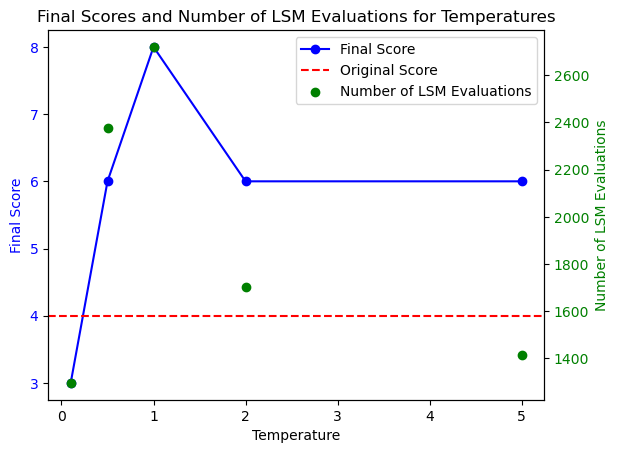

r2
r3
[<Reaction Random_Rxn_1 at 0x28d45c410>, <Reaction Random_Rxn_2 at 0x28d554e90>, <Reaction Random_Rxn_3 at 0x28aa8e810>, <Reaction Random_Rxn_4 at 0x28aa8f950>, <Reaction Random_Rxn_5 at 0x28e058950>, <Reaction Random_Rxn_6 at 0x28e59a410>, <Reaction Random_Rxn_7 at 0x28e4cc910>, <Reaction Random_Rxn_8 at 0x29063e790>, <Reaction Random_Rxn_9 at 0x28d0ac110>, <Reaction Random_Rxn_10 at 0x28d0afcd0>, <Reaction Random_Rxn_11 at 0x28d0af2d0>, <Reaction Random_Rxn_12 at 0x28e6bdc50>, <Reaction Random_Rxn_13 at 0x28e598510>, <Reaction Random_Rxn_14 at 0x28e6bd690>, <Reaction Random_Rxn_15 at 0x28d0af690>, <Reaction Random_Rxn_16 at 0x28e6bcb10>, <Reaction Random_Rxn_17 at 0x28e6be9d0>, <Reaction Random_Rxn_18 at 0x28e6bce90>, <Reaction Random_Rxn_19 at 0x28e6bf5d0>, <Reaction Random_Rxn_20 at 0x28e6bfc90>, <Reaction Random_Rxn_21 at 0x28e6be0d0>, <Reaction Random_Rxn_22 at 0x28e6bf910>, <Reaction Random_Rxn_23 at 0x28e6bd550>, <Reaction Random_Rxn_24 at 0x28e6bfb90>, <Reaction Random_R

[12.000000055083037, 5.121320556327037, 9.859363691925559, 5.3237901338369795, 12.000000051052128, 5.3237901616196215, 12.000000028137855, 12.000000070723214, 12.000000068787855, 12.000003714918906, 12.000000055083037, 12.000000028137855, 12.00000002813786, 12.000000102215244, 12.000000042558941, 9.803360570671892, 9.859363717646875, 12.000000051052128, 12.000000064450944, 12.000000040814237, 12.000000070943539, 12.00000005508656, 3.000004078988023, 3.000004114830098, 12.000000055047098, 12.000000057679621, 12.000000070723218, 3.000004038387881, 9.859363717646875, 12.000000266930057, 12.000000055047066, 12.000000099327625, 5.323790136255609, 12.00000005108484, 5.121320608880245, 3.0000041922123843, 12.000000038402012, 5.121320608880245, 12.00000002813786, 12.000000099327625, 12.00000007094355, 5.323790161618638, 12.000000055082669, 3.0000040837920228, 12.000000050157293, 5.323790136255609, 12.000000042558941, 12.000000040814237]
[0.01348163 0.03158943 0.01640872 0.03038805 0.01348163 0

[5.121320579691531, 8.121320403588435, 5.121320575598565, 3.0000001602068265, 5.1213204497952916, 7.50000001904366, 7.018686996919166, 5.121320579691531, 8.121320362316162, 7.50000001904366, 6.794733262416605, 5.121320506852243, 7.897366659613591, 8.121320377125773, 3.0000001602068265, 8.12132036096597, 8.121320407582754, 7.500000068357371, 8.121320379161919, 7.500000035919137, 7.500000067133399, 8.12132036094725, 7.897366615810134, 8.12132037687881, 7.500000017052365, 5.121320491160331, 7.018686996813453, 5.1213205062798455, 5.121320462239825, 3.0000001602063273, 7.500000019407681, 7.500000010518347, 8.121320408774846, 7.50000001904366, 5.1213205062798455, 8.121320420381803, 8.1213205674367, 7.500000059744969, 8.12132037642267, 5.121320462239825, 5.121320506852243, 8.121320407582754]
[0.02652968 0.02106734 0.02652968 0.0346627  0.02652968 0.02192262
 0.02266183 0.02652968 0.02106734 0.02192262 0.02303227 0.02652968
 0.02136396 0.02106734 0.0346627  0.02106734 0.02106734 0.02192262
 0.

[5.000000290096941, 5.000000344254153, 20.00000016241634, 5.000000248581121, 20.000000178116892, 20.00000014008732, 20.00000015824562, 20.00000014816555, 5.000000297576116, 5.000000350487127, 20.000000147537563, 20.000000274244115, 20.000000327651016, 20.000000192871823, 5.000000234364698, 5.0000003417535845, 20.00000019286942, 20.000000161123275, 20.000000131782315, 5.000000342675875, 5.000000350487127, 20.000000192871774, 20.000000144401486, 5.000000356512439, 20.000000120839474, 5.000000299673214, 20.00000014885265, 5.000000257806417, 20.000000144401486, 20.00000032528213, 20.000000162417027, 5.000000215324252, 20.00000018271851, 5.000000356512439, 20.000000274244115]
[0.03342802 0.03342802 0.0253337  0.03342802 0.0253337  0.0253337
 0.0253337  0.0253337  0.03342802 0.03342802 0.0253337  0.0253337
 0.0253337  0.0253337  0.03342802 0.03342802 0.0253337  0.0253337
 0.0253337  0.03342802 0.03342802 0.0253337  0.0253337  0.03342802
 0.0253337  0.03342802 0.0253337  0.03342802 0.0253337 

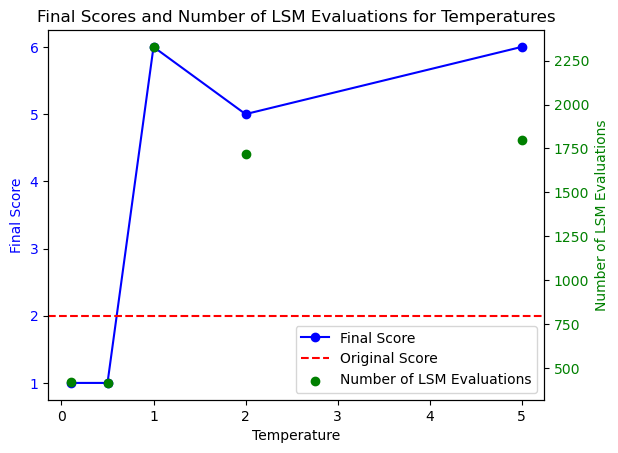

r2
r3
r5
[<Reaction Random_Rxn_1 at 0x28e07d390>, <Reaction Random_Rxn_2 at 0x29251c0d0>, <Reaction Random_Rxn_3 at 0x28d17eb90>, <Reaction Random_Rxn_4 at 0x28ca54e90>, <Reaction Random_Rxn_5 at 0x285562490>, <Reaction Random_Rxn_6 at 0x2855637d0>, <Reaction Random_Rxn_7 at 0x285560710>, <Reaction Random_Rxn_8 at 0x285561910>, <Reaction Random_Rxn_9 at 0x28c9fda90>, <Reaction Random_Rxn_10 at 0x285560950>, <Reaction Random_Rxn_11 at 0x285563450>, <Reaction Random_Rxn_12 at 0x285563ed0>, <Reaction Random_Rxn_13 at 0x28afdb9d0>, <Reaction Random_Rxn_14 at 0x285562ed0>, <Reaction Random_Rxn_15 at 0x28cf7b5d0>, <Reaction Random_Rxn_16 at 0x285561a50>, <Reaction Random_Rxn_17 at 0x28cf793d0>, <Reaction Random_Rxn_18 at 0x28cf79290>, <Reaction Random_Rxn_19 at 0x2855628d0>, <Reaction Random_Rxn_20 at 0x285561790>, <Reaction Random_Rxn_21 at 0x28cc42ad0>, <Reaction Random_Rxn_22 at 0x28cf798d0>, <Reaction Random_Rxn_23 at 0x28cf7a490>, <Reaction Random_Rxn_24 at 0x28cf7b390>, <Reaction Rando

[21.902894738801198, 21.902894726152393, 21.90289472569127, 3.00000021106204, 21.90289473276571, 3.0000002510470987, 3.0000001527646902, 21.902894732770818, 21.90289473276571, 21.902894732821913, 3.0000001360063164, 10.42669808034587, 21.902894737192824, 3.0000001902462623, 3.000000129809118, 3.0000001958595632, 21.90289473276807, 3.0000001681249393, 21.90289472508702, 21.9028947327865, 3.0000002012795717, 3.0000001726833725, 21.902894726152393, 3.0000002076176018, 3.000016860529098, 21.90289472508702, 10.426698102620755, 21.902894730658396, 21.902894732769763, 21.90289473275969, 21.902894737192824, 21.902894732768125, 10.426698102620755, 21.902894732768125, 21.90289472512164, 10.42669809003735, 21.902894732755495, 3.000000206290694, 21.902894732757886, 21.90289472639768, 3.0000002236020213, 21.90289472615185, 21.902894726241577, 3.0000002236020213, 3.0000001548788937, 21.902894732768125, 21.90289472639768, 3.0000001786300854, 3.000016867240435]
[0.00099589 0.00099589 0.00099589 0.0530

[19.820635209274535, 14.60192982579499, 18.604062889159383, 19.82063520926484, 9.120302005621474, 19.820635209263187, 19.82063520926484, 17.454813252850265, 9.618802213220343, 14.601929825904428, 17.454813223633995, 6.7976090169402275, 15.656854281523845, 19.82063520926516, 14.727406619531465, 14.60192982577111, 19.820635209265895, 17.45481326467321, 15.65685427072479, 14.60192982579499, 11.018293436321471, 5.000000053311394, 14.60192982577111, 9.618802213220345, 19.82063520926263, 19.820635209274602, 14.60192982582497, 19.820635209264978, 9.618802213220345, 19.820635209264715, 19.82063520926736, 5.000000017249336, 5.000000019834751, 19.820635209262374, 18.604062877195812, 14.727406619615568, 14.60192982579502, 19.820635200354687, 14.727406619612944, 14.727406619531596, 18.604062877195812, 5.000000030728229, 5.000000053309036]
[0.01882385 0.02193119 0.01942958 0.01882385 0.02774998 0.01882385
 0.01882385 0.02005902 0.02702133 0.02193119 0.02005902 0.0321432
 0.02117946 0.01882385 0.021

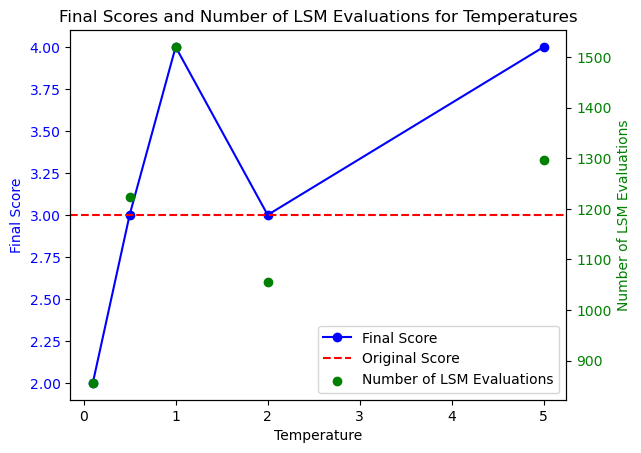

r7
r2
r6r
r5
[<Reaction Random_Rxn_1 at 0x28e12add0>, <Reaction Random_Rxn_2 at 0x28c57f510>, <Reaction Random_Rxn_3 at 0x28d033cd0>, <Reaction Random_Rxn_4 at 0x2854c4190>, <Reaction Random_Rxn_5 at 0x28d031b50>, <Reaction Random_Rxn_6 at 0x28d031a90>, <Reaction Random_Rxn_7 at 0x28e12a450>, <Reaction Random_Rxn_8 at 0x28c7c8310>, <Reaction Random_Rxn_9 at 0x28d4831d0>, <Reaction Random_Rxn_10 at 0x28e124950>, <Reaction Random_Rxn_11 at 0x28c60e710>, <Reaction Random_Rxn_12 at 0x28c7cbc10>, <Reaction Random_Rxn_13 at 0x28c60e850>, <Reaction Random_Rxn_14 at 0x28c60e950>, <Reaction Random_Rxn_15 at 0x28c60c910>, <Reaction Random_Rxn_16 at 0x2854bad90>, <Reaction Random_Rxn_17 at 0x28c60cc10>, <Reaction Random_Rxn_18 at 0x28c60ced0>, <Reaction Random_Rxn_19 at 0x28c60e9d0>, <Reaction Random_Rxn_20 at 0x28c60d4d0>, <Reaction Random_Rxn_21 at 0x28c60ccd0>, <Reaction Random_Rxn_22 at 0x28c60c310>, <Reaction Random_Rxn_23 at 0x28d7a0b90>, <Reaction Random_Rxn_24 at 0x28d7a00d0>, <Reaction R

[18.502963790054817, 22.4347559005169, 14.727504585670491, 22.43429958218119, 19.08235551195972, 23.14878763432208, 23.148787634322304, 18.98357099945139, 23.14878763432234, 18.998555689056534, 23.148787634322304, 21.16324883708422, 23.148787634322304, 20.062957280514983, 18.176896353131525, 18.50296379010983, 23.14878763432231, 23.14878763432228, 18.99855567383885, 18.502963790054817, 23.148787634322296, 19.082355498507848, 18.998555689056534, 19.655129474778278, 22.43429958218119, 20.062957280514983, 14.893620240615107, 19.34846922836027, 23.1487876343223, 19.08235551195972, 19.082355498507848, 15.048766272301775, 14.893620240615107, 19.08235551195972, 23.1487876343223, 23.1487876343223, 17.45481322062856, 23.148787634322286, 14.893620210141831, 15.048766272301771, 14.727504553441484, 15.048766272173312, 23.14878763432208, 23.14878763432229, 19.655129474824314, 18.998555689056534, 14.727504585670491, 15.80496539295445]
[0.02173263 0.01478265 0.03430335 0.01478325 0.02043294 0.0138847

[15.686212649253982, 13.484401522255965, 17.276672458885123, 17.276672473812997, 14.951910702588913, 17.276672470156836, 10.348469245568257, 14.82718272803778, 11.363081143191913, 17.276672470156836, 16.948503071169473, 12.667058114900993, 8.58542204878799, 13.812570857291398, 16.659558062176863, 12.049523664480729, 15.686212649253982, 13.561171460675801, 17.276672490371958, 10.348469245568259, 12.438793185526622, 17.276672458885123, 16.948503071169473, 13.095131994847277, 13.095131978310969, 17.232533904944134, 17.276672473812997, 17.276672490371958, 13.095131994847277, 17.276672470345943, 8.913591401993402, 13.233002069696402, 16.62033367175191, 13.233002083599747, 13.233002063568573, 13.095131950617258, 17.27667247034659, 17.276672470351954, 14.951910702588913, 13.095131970374554, 15.686212660780452, 13.812570845825146, 13.81257092902372, 8.913591396581461]
[0.02015211 0.02344266 0.01829694 0.01829694 0.0211418  0.01829694
 0.03054658 0.02131965 0.02781907 0.01829694 0.01865122 0.02

[7.863155664435529, 44.56678010958519, 4.000000275419497, 4.000000196748151, 48.98431291678531, 4.00000022919876, 48.98431291678569, 20.776335062170865, 6.520918398318052, 48.98431291678478, 47.41763236034823, 7.863155664435529, 47.417632360344406, 4.000000191176643, 4.00000022919876, 11.447229547771595, 44.56678010958519, 48.98431291678488, 20.776334761430494, 44.5667801095938, 48.984312916785726, 4.000000275419497, 4.000000191176643, 20.776334761430494, 48.98431291678585, 48.984312916785534, 11.44723263206572, 48.98431291678534, 32.97056279450908, 11.447229448926109, 26.751885618069565, 26.751885642454102, 4.000000196748151, 48.98431291678527, 34.537243345748465, 4.00000022919876, 34.53724333301186]
[0.0353906  0.01486554 0.04961995 0.04961995 0.0141794  0.04961995
 0.0141794  0.02177218 0.03886261 0.0141794  0.01441174 0.0353906
 0.01441174 0.04961995 0.04961995 0.02933163 0.01486554 0.0141794
 0.02177218 0.01486554 0.0141794  0.04961995 0.04961995 0.02177218
 0.0141794  0.0141794  

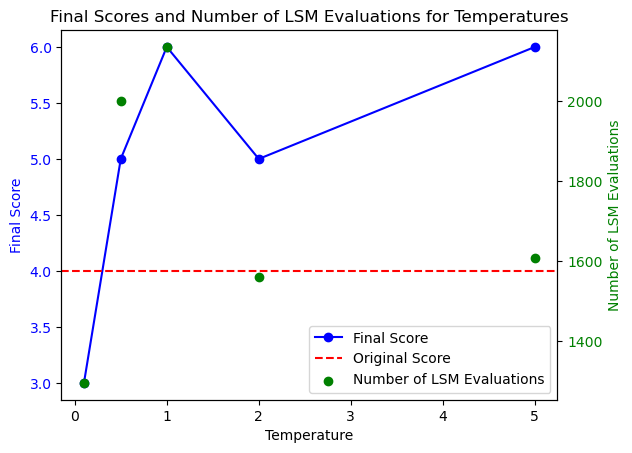

r7
r6r
[<Reaction Random_Rxn_1 at 0x28e4c3310>, <Reaction Random_Rxn_2 at 0x285413990>, <Reaction Random_Rxn_3 at 0x28ca5f3d0>, <Reaction Random_Rxn_4 at 0x28c931d90>, <Reaction Random_Rxn_5 at 0x28cf71590>, <Reaction Random_Rxn_6 at 0x28cbfbed0>, <Reaction Random_Rxn_7 at 0x28cbfbf90>, <Reaction Random_Rxn_8 at 0x28cbf92d0>, <Reaction Random_Rxn_9 at 0x28cbfacd0>, <Reaction Random_Rxn_10 at 0x28cbfa850>, <Reaction Random_Rxn_11 at 0x28c82f090>, <Reaction Random_Rxn_12 at 0x28c82d310>, <Reaction Random_Rxn_13 at 0x28cbfb290>, <Reaction Random_Rxn_14 at 0x28c82c250>, <Reaction Random_Rxn_15 at 0x28cbfb090>, <Reaction Random_Rxn_16 at 0x28c82c110>, <Reaction Random_Rxn_17 at 0x28c82c590>, <Reaction Random_Rxn_18 at 0x28c82cf10>, <Reaction Random_Rxn_19 at 0x28c82fb50>, <Reaction Random_Rxn_20 at 0x28c82d710>, <Reaction Random_Rxn_21 at 0x28c82e590>, <Reaction Random_Rxn_22 at 0x28c82e4d0>, <Reaction Random_Rxn_23 at 0x28c82c6d0>, <Reaction Random_Rxn_24 at 0x2906cc6d0>, <Reaction Random_

[10.081097301303913, 7.966864320962465, 7.809504992243091, 7.453706641781203, 10.081097303182233, 10.081097328710792, 3.000000139770143, 8.585422139617979, 5.773938344026432, 10.081097320462371, 7.2627955237286725, 7.575047825353419, 7.804602074251802, 8.585422080287033, 9.643990644935835, 8.739456576411104, 10.081097471521556, 7.2627955237286725, 5.683281693982392, 8.585423642495027, 9.927062935889866, 8.585422139617979, 7.804602111655017, 5.683281693982392, 8.273169810497834, 6.462961210846949, 8.58542218100688, 5.683281663264173, 9.927063000854659, 9.927062880941424, 6.462961210846949, 9.394110291689191, 7.809504992243091, 10.08109735554263, 9.643990647792947, 8.585422136665512, 8.585422139617979, 9.489956168632041, 8.58542218100688, 8.585428800192355, 10.081097345775005, 9.927063084425388, 10.081097301303913, 8.585422115569422, 5.683281889974589, 10.081097342126974, 3.0000001905480858, 8.585422341871773]
[0.01059532 0.01696504 0.01765561 0.0193814  0.01059532 0.01059532
 0.11964296

[12.228279030278216, 12.544459259426963, 5.0000002847833755, 12.40851747620756, 12.544452780424205, 12.071067978559952, 8.65148397004492, 6.889822761558987, 5.000000308231797, 11.45497270018467, 12.54445274817976, 7.041241828297586, 5.000000255184581, 12.071068045726157, 6.889822761558987, 6.889822825977375, 6.8898226882045694, 5.000000366462258, 12.071067978559952, 11.454972486158788, 6.889822825977375, 12.000000226716985, 12.071068177570885, 12.07106811326501, 12.54445274952387, 12.544452694151506, 12.544452886026425, 12.544452885270037, 12.544453267405348, 12.544452798981723, 12.408517455177343, 12.071067978559952, 5.000000418497025, 12.071068177570885, 12.408517486265595, 12.071067996100666, 12.54445281073064, 10.000000293950912, 12.408517428822762, 6.889822698736303, 5.000000311503625, 6.889822780609144]
[0.01741591 0.01697694 0.04259331 0.01716294 0.01697695 0.01764273
 0.02461619 0.03091031 0.04259331 0.01859163 0.01697695 0.0302456
 0.04259331 0.01764273 0.03091031 0.03091031 0

[4.0854697706863305, 4.085469788955464, 4.018895110383593, 5.064933655213863, 4.22272370959398, 3.4905024714603354, 3.6161286303820317, 4.280238979978456, 3.3656899460438705, 5.064932696033793, 4.018895098569153, 3.033131752948666, 4.687426490884799, 3.439157628727421, 4.22272370959398, 3.6161286293382497, 3.033131752948666, 4.959984948957777, 4.222723706082997, 3.4494915777678483, 5.1311822397786635, 4.84689996566171, 3.5157401370715, 4.589576223713392, 5.131182345299843, 5.131182284547023, 4.2802389950963615, 4.22272370959398, 4.37944549784873, 4.222723717568433, 5.131182247438254, 5.131182341327745, 4.379445765650225, 5.093846795076919, 1.774596762419228]
[0.02858714 0.02858714 0.02868123 0.02738447 0.02839884 0.02950133
 0.02929344 0.02832211 0.02971696 0.02738447 0.02868123 0.03034177
 0.027812   0.02958889 0.02839884 0.02929344 0.03034177 0.02749939
 0.02839884 0.02957114 0.02731339 0.02762653 0.02945885 0.02792959
 0.02731339 0.02731339 0.02832211 0.02839884 0.02819261 0.0283988

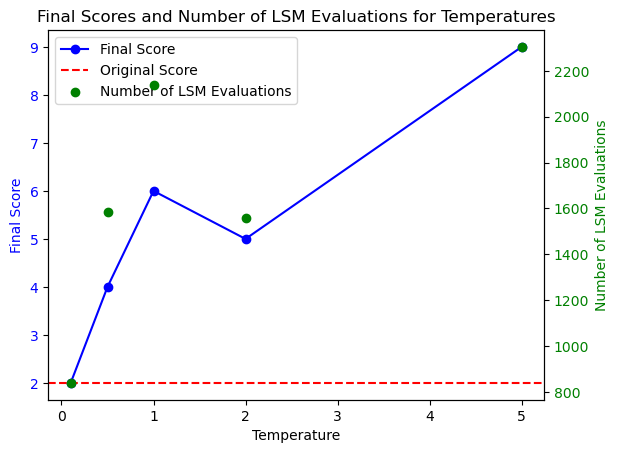

r6r
r5
r3
[<Reaction Random_Rxn_1 at 0x28aa5fd90>, <Reaction Random_Rxn_2 at 0x28d14f8d0>, <Reaction Random_Rxn_3 at 0x28e2ae210>, <Reaction Random_Rxn_4 at 0x28cae0410>, <Reaction Random_Rxn_5 at 0x28cb37310>, <Reaction Random_Rxn_6 at 0x28e13d5d0>, <Reaction Random_Rxn_7 at 0x28af8f290>, <Reaction Random_Rxn_8 at 0x28c541750>, <Reaction Random_Rxn_9 at 0x28aefdbd0>, <Reaction Random_Rxn_10 at 0x28e13f010>, <Reaction Random_Rxn_11 at 0x28e086990>, <Reaction Random_Rxn_12 at 0x285496490>, <Reaction Random_Rxn_13 at 0x285495050>, <Reaction Random_Rxn_14 at 0x285495150>, <Reaction Random_Rxn_15 at 0x28d1139d0>, <Reaction Random_Rxn_16 at 0x28c8ab290>, <Reaction Random_Rxn_17 at 0x28c98f250>, <Reaction Random_Rxn_18 at 0x28d112ad0>, <Reaction Random_Rxn_19 at 0x285496750>, <Reaction Random_Rxn_20 at 0x28cb16210>, <Reaction Random_Rxn_21 at 0x28c98e210>, <Reaction Random_Rxn_22 at 0x28c98ddd0>, <Reaction Random_Rxn_23 at 0x28c98e810>, <Reaction Random_Rxn_24 at 0x28c49ab50>, <Reaction Rand

[25.237604356459393, 18.14213571532026, 23.313708637392242, 10.00000007641176, 26.14213562524187, 30.283240345635186, 18.142135702438814, 18.142135765836493, 9.059644412572332, 10.000000111663164, 30.28324035145431, 28.719724286135357, 9.35824935176604, 30.283240359041756, 29.454813234344297, 29.454813234344297, 29.454813222122002, 30.283240346808494, 27.454813315164206, 30.28324034687776, 10.828427197037204, 30.283240350368843, 9.059644386723187, 29.454813234344297, 18.14213574228787, 30.283240358411653, 30.283240359041756, 18.14213575630484, 30.283240359041756, 30.28324034921435, 30.283240358468767, 10.000000078825243, 30.283240358468767, 9.059644350100696, 10.828427197037204, 18.142135715820356, 16.568930759145957, 9.059644350100696, 18.142135715820356, 27.454813271039473, 29.98463535023371, 30.283240346327432, 30.28324036011775, 18.142135702438814, 23.31370860012504, 23.313708545383776, 10.828427197037204, 18.14213571854581]
[0.00871589 0.01686674 0.01021375 0.05551471 0.00812318 0

[27.895996542639573, 29.203859635604516, 29.203859639836864, 29.20385963562684, 24.328806815455973, 32.91102923973667, 29.203859635994938, 29.203859635256947, 32.91102923743536, 32.91102924419049, 4.000000271053933, 32.911029239711176, 32.911029239711176, 32.91102923945509, 32.812104325685695, 32.91102925533394, 32.91102923955992, 4.000000246597018, 32.911029239409814, 7.265986594907248, 32.911029239711176, 7.265986599731864, 32.91102923972856, 32.911029239763174, 32.911029239751606, 29.203859638455437, 25.651586623527745, 4.0000002419289755, 25.651586623527745, 7.2659866505608575, 4.000000246597018, 29.20385964011006, 7.2659866505608575, 17.85640660576893, 29.62638837607362, 32.91102923973507, 32.81210432537139, 32.21583713768756, 29.203859636488875, 4.000000246597018, 17.856406632705777]
[0.01239321 0.01183819 0.01183819 0.01183819 0.01421035 0.01050471
 0.01183819 0.01183819 0.01050471 0.01050471 0.08643022 0.01050471
 0.01050471 0.01050471 0.01053638 0.01050471 0.01050471 0.0864302

[9.940279654185206, 9.910317604636184, 10.440194532313708, 10.440194573834027, 9.499277838661575, 10.440194532310144, 10.440194532310546, 10.440194532313708, 5.5692589146990565, 8.90667237139631, 10.440194532313708, 9.499277840011153, 10.440194527839981, 6.449489758927767, 8.859905776037346, 10.440194532314866, 10.440194529284096]
[0.05817455 0.05820969 0.05760644 0.05760644 0.05870494 0.05760644
 0.05760644 0.05760644 0.06532107 0.05946613 0.05760644 0.05870494
 0.05760644 0.0634319  0.05952878 0.05760644 0.05760644]
7
[18.998555689138257, 15.727406619415031, 20.880389064497734, 18.99855567078112, 20.880389064620324, 20.88038906462051, 20.88038906462095, 20.88038906462978, 8.000000053311233, 11.138517829497301, 20.88038906462051, 20.880389064620463, 20.880389064497734, 18.99855567988609, 20.880389055680045, 15.141620181905056, 8.0000000533111, 15.141620181905056, 12.89897949696536, 8.000000053311233, 20.880389064620324, 17.719811552051823, 20.880389064629902, 20.880389064629952, 15.72

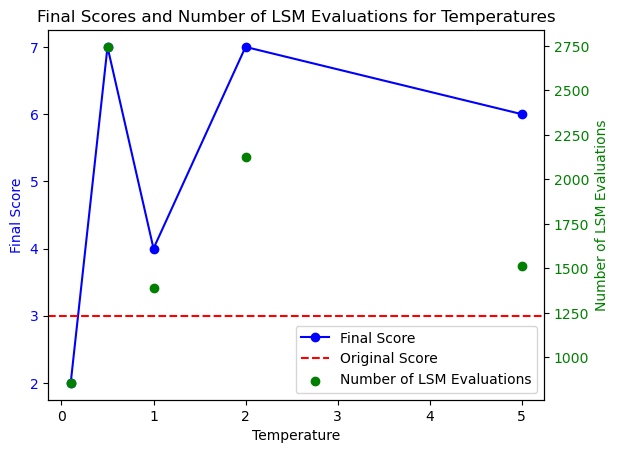

r2
r3
r5
r6r
[<Reaction Random_Rxn_1 at 0x28c872350>, <Reaction Random_Rxn_2 at 0x28caeba50>, <Reaction Random_Rxn_3 at 0x28cb1f390>, <Reaction Random_Rxn_4 at 0x28ca878d0>, <Reaction Random_Rxn_5 at 0x28554fc10>, <Reaction Random_Rxn_6 at 0x28caeb810>, <Reaction Random_Rxn_7 at 0x28cfa0050>, <Reaction Random_Rxn_8 at 0x28d2b1790>, <Reaction Random_Rxn_9 at 0x2854c7010>, <Reaction Random_Rxn_10 at 0x28ae9c090>, <Reaction Random_Rxn_11 at 0x28d1d8710>, <Reaction Random_Rxn_12 at 0x28d1d8c90>, <Reaction Random_Rxn_13 at 0x28af1ac90>, <Reaction Random_Rxn_14 at 0x28af19a10>, <Reaction Random_Rxn_15 at 0x28cae9e50>, <Reaction Random_Rxn_16 at 0x28af18590>, <Reaction Random_Rxn_17 at 0x28af1ae50>, <Reaction Random_Rxn_18 at 0x28af1a690>, <Reaction Random_Rxn_19 at 0x28af1b290>, <Reaction Random_Rxn_20 at 0x28af1a250>, <Reaction Random_Rxn_21 at 0x28af18750>, <Reaction Random_Rxn_22 at 0x28af18210>, <Reaction Random_Rxn_23 at 0x28af18390>, <Reaction Random_Rxn_24 at 0x28af1a310>, <Reaction R

[10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532246377, 10.440194532313708, 10.440194532313708, 10.440194532313708, 11.092303242878415, 10.440194532313708, 10.440194532309942, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.765598485702672, 10.440194532313708, 10.440195366753308, 10.440194532313708, 10.440194532313708, 10.440195366753308, 10.440194532313708, 10.440194532309942, 10.440194532313708, 10.440194532313708]
[0.0346905  0.0346905  0.0346905  0.0346905  0.0346905  0.0346905
 0.0346905  0.0346905  0.03073153 0.0346905  0.0346905  0.0346905
 0.0346905  0.0346905  0.0346905  0.0346905  0.0346905  0.0346905
 0.0346905  0.03262506 0.0346905  0.03469049 0.0346905  0.0346905
 0.03469049 0.0346905  0.0346905  0.0346905  0.0346905 ]
0
[20.88038905568011, 20.880389057789145, 20.880389057789145, 20.880389064627764, 20.8803890556801

[10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 11.092303242878415, 10.440194532313708, 10.440194532309942, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.765598485702672, 10.440194532313708, 10.440194532313708, 10.440195366753308, 10.440194532313708, 10.440194532309942, 10.440194532313708, 10.440194532313708]
[0.04182178 0.04182178 0.04182178 0.04182178 0.04182178 0.03936311
 0.04182178 0.04182178 0.04182178 0.04182178 0.04182178 0.04182178
 0.04182178 0.04182178 0.04182178 0.04182178 0.04055767 0.04182178
 0.04182178 0.04182178 0.04182178 0.04182178 0.04182178 0.04182178]
5
[20.88161123110185, 15.727406619581053, 20.880389064628048, 20.88038906462959, 20.88161123110185, 15.141620181913941, 20.88039073349979, 12.898979501276461, 15.141620181799617, 18.99855567731534, 13.219473293593792, 18.08681836820111, 18.0868183682

[10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532309942, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.765598485702672, 10.440194532313708, 10.440194532313708, 10.440194532313708, 10.440194532309942, 10.440194532313708]
[0.04765361 0.04765361 0.04765361 0.04765361 0.04765361 0.04765361
 0.04765361 0.04765361 0.04765361 0.04765361 0.04765361 0.04765361
 0.04765361 0.04765361 0.04765361 0.04692788 0.04765361 0.04765361
 0.04765361 0.04765361 0.04765361]
5
[20.880389055680034, 20.880389057789145, 20.880389057789145, 20.880389064627764, 20.880389064620346, 17.454813252881593, 19.820635209272293, 20.880389064620132, 12.89897951783273, 20.880389064618733, 20.880389064621003, 17.454813252881593, 17.719811531347254, 19.820635209272293, 20.880389064622484, 19.820635209275018, 19.820635200180917, 1

[10.000000034736072, 10.000000116239406, 10.000000057582026, 4.00000020098398, 10.000000076179543, 10.000000070784614, 10.000000070628655, 4.00000020098398, 10.000000076179541, 10.000000076179498, 10.000000061956168, 10.000000076179498, 4.0000002672463255, 10.000000015460191, 5.511858062353557, 4.000000382664503, 10.000000078875567, 10.000000057582026, 10.000000087048026, 10.000000075763213, 4.000001010927353, 10.000000045367281, 4.000000146987887, 10.000000057582024, 10.000000015460191]
[0.03797477 0.03797477 0.03797477 0.04561243 0.03797477 0.03797477
 0.03797477 0.04561243 0.03797477 0.03797477 0.03797477 0.03797477
 0.04561243 0.03797477 0.04277949 0.04561243 0.03797477 0.03797477
 0.03797477 0.03797477 0.04561243 0.03797477 0.04561243 0.03797477
 0.03797477]
0
[12.500000124945728, 12.500000046286122, 5.00000027196088, 12.500000125490129, 12.5000001264347, 12.500000088183505, 5.00000027196088, 12.500000125490129, 12.500000125488677, 12.500000093641221, 12.500000125488677, 5.0000003

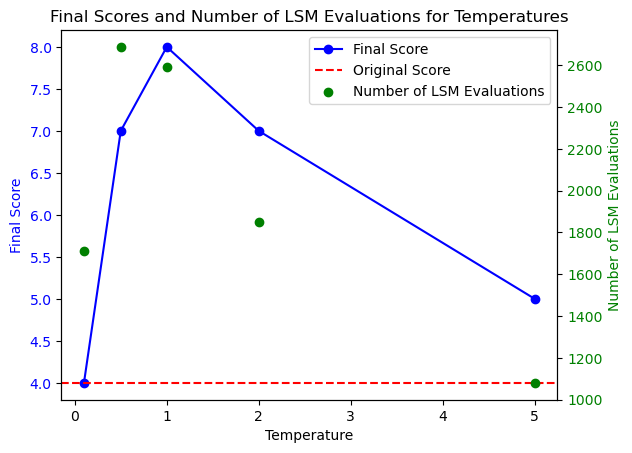

r3
r6r
[<Reaction Random_Rxn_1 at 0x28cb091d0>, <Reaction Random_Rxn_2 at 0x28e6e5e10>, <Reaction Random_Rxn_3 at 0x28e138bd0>, <Reaction Random_Rxn_4 at 0x28e59bed0>, <Reaction Random_Rxn_5 at 0x28e598410>, <Reaction Random_Rxn_6 at 0x28e59ad90>, <Reaction Random_Rxn_7 at 0x28d75cc10>, <Reaction Random_Rxn_8 at 0x28e55c190>, <Reaction Random_Rxn_9 at 0x28e59b990>, <Reaction Random_Rxn_10 at 0x28e55e2d0>, <Reaction Random_Rxn_11 at 0x28e55d1d0>, <Reaction Random_Rxn_12 at 0x28e55ce50>, <Reaction Random_Rxn_13 at 0x28e59aa90>, <Reaction Random_Rxn_14 at 0x28cf0eb50>, <Reaction Random_Rxn_15 at 0x28e13a6d0>, <Reaction Random_Rxn_16 at 0x28e13a8d0>, <Reaction Random_Rxn_17 at 0x28d76f4d0>, <Reaction Random_Rxn_18 at 0x28e55ef50>, <Reaction Random_Rxn_19 at 0x28c44c0d0>, <Reaction Random_Rxn_20 at 0x28e55f410>, <Reaction Random_Rxn_21 at 0x28e55d150>, <Reaction Random_Rxn_22 at 0x28e55ec10>, <Reaction Random_Rxn_23 at 0x2925f7b10>, <Reaction Random_Rxn_24 at 0x28e55d7d0>, <Reaction Random_

[4.000000019865422, 4.000000018967649, 4.000000019865422, 4.000000018967649, 3.28645458798419, 10.440194532316356, 10.440194532316449, 2.7071068043387716, 4.000000026655657, 4.000000026655613, 4.0000000180339725, 4.000000003717115, 9.65785900958871, 4.0000000183364985, 4.000005580872197, 4.00000002665695, 4.000000018037461, 2.7071068043387716, 4.00000002665548, 4.000000018333404, 3.4062851082195147, 10.440194532316356, 4.000000026660345, 4.000000026658025, 4.000000026657997, 2.7071068043387716, 4.000000026655617, 4.000000026655632, 4.000000018032811, 4.0000000037171555, 9.910390529686971, 10.440194532310443, 4.000000014736985, 1.7745967686078163]
[0.02991455 0.02991455 0.02991455 0.02991455 0.03640951 0.0114613
 0.0114613  0.0442015  0.02991455 0.02991455 0.02991455 0.02991455
 0.01238972 0.02991455 0.02991451 0.02991455 0.02991455 0.0442015
 0.02991455 0.02991455 0.03512865 0.0114613  0.02991455 0.02991455
 0.02991455 0.0442015  0.02991455 0.02991455 0.02991455 0.02991455
 0.01207401 

[5.414213596759332, 2.000000069746949, 5.00000003336341, 2.000000069746949, 3.414213644202723, 5.414213604778328, 3.4142136139077293, 5.414213608778475, 2.000000093793882, 3.664100623008563, 5.414213608777703, 5.414213593696788, 5.414213573629901, 5.414213609211267, 2.0000000904128967, 2.0000000800977715, 5.414213619056077, 3.414213665676376, 3.414213695130166, 5.0000000561470035, 5.414213612775486, 2.000000171615471, 5.000000053549789, 5.414213610170139, 3.414213697927897, 5.000000014789542, 4.003827614490827, 5.414213608778475, 4.529822289719393, 5.414213610227063, 5.414213606447355, 5.000000046914394, 3.414213637377962, 5.4142136092112665, 5.0000000401989, 5.00000006150049, 3.414213652146535, 5.41421360205611, 2.0000000894800043, 3.414213780747157]
[0.02112047 0.03475011 0.0219779  0.03475011 0.02659658 0.02112047
 0.02659658 0.02112047 0.03475011 0.02567364 0.02112047 0.02112047
 0.02112047 0.02112047 0.03475011 0.03475011 0.02112047 0.02659658
 0.02659658 0.0219779  0.02112047 0.0

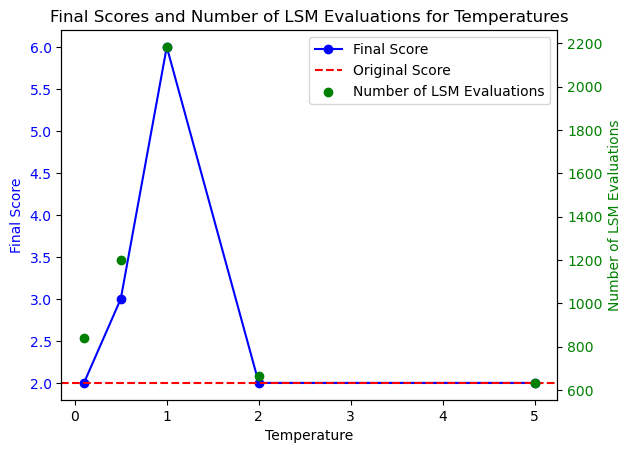

r5
r3
r7
[<Reaction Random_Rxn_1 at 0x28e07fb90>, <Reaction Random_Rxn_2 at 0x28c614e90>, <Reaction Random_Rxn_3 at 0x28c953710>, <Reaction Random_Rxn_4 at 0x28b0aed90>, <Reaction Random_Rxn_5 at 0x28e0f4910>, <Reaction Random_Rxn_6 at 0x28d030050>, <Reaction Random_Rxn_7 at 0x28ccfb190>, <Reaction Random_Rxn_8 at 0x28ccfa790>, <Reaction Random_Rxn_9 at 0x28ccfa3d0>, <Reaction Random_Rxn_10 at 0x28d06a4d0>, <Reaction Random_Rxn_11 at 0x28ccf9ed0>, <Reaction Random_Rxn_12 at 0x28b0ae110>, <Reaction Random_Rxn_13 at 0x28ccfb310>, <Reaction Random_Rxn_14 at 0x28ccfb2d0>, <Reaction Random_Rxn_15 at 0x28ccf9150>, <Reaction Random_Rxn_16 at 0x28ccf9b10>, <Reaction Random_Rxn_17 at 0x28ccfa0d0>, <Reaction Random_Rxn_18 at 0x28ccf9890>, <Reaction Random_Rxn_19 at 0x28ccfb250>, <Reaction Random_Rxn_20 at 0x28cb1ed50>, <Reaction Random_Rxn_21 at 0x28cb1e450>, <Reaction Random_Rxn_22 at 0x28cb1eed0>, <Reaction Random_Rxn_23 at 0x28cb1e710>, <Reaction Random_Rxn_24 at 0x28ae4c890>, <Reaction Rando

[21.281217263456288, 12.049523660657153, 12.66817115747582, 25.083739309109987, 21.283240359989215, 25.083739287867918, 21.413484604706593, 12.668171455769695, 11.729888317164077, 25.083739299301843, 24.2659758269482, 25.083739289376183, 25.08373929312268, 21.413484606222614, 21.28121820658762, 24.437068393006143, 17.67416992333053, 25.083739300493466, 21.413484608441664, 12.049523600090028, 12.668171308933498, 21.281217252297264, 25.083740665752988, 25.083742252908884, 3.0000001231781517, 21.281217240555673, 21.41348461107591, 18.564455317193328, 21.283242511342838, 25.083739300493466, 3.0000001803588257, 3.000000146841727, 21.41348461184832, 12.049523624979638, 25.083739289376183, 21.41348460498265, 25.083739292103353, 21.41348460929381, 24.437068335385995, 11.729888317164077, 25.083742081816418, 25.083739299301843, 25.083742449613936, 21.41348461184832, 8.913592042267807, 25.083739288851255, 21.28121820658762, 25.08373929498554, 8.913591434252853]
[0.00458214 0.01429295 0.01293105 0

[4.000000210004636, 4.0000002000278565, 23.313709782212023, 23.313708502070487, 4.000000235869934, 23.313708508113038, 4.0000002734218105, 4.000000282732449, 23.31370856405813, 4.000000263181252, 23.313708503364253, 4.000000246705191, 23.313708503364005, 4.000000248472503, 23.313708500194334, 4.000000185953404, 23.313712285577378, 23.313708500772005, 4.000000280980395, 4.0000002937983075, 23.31370850835168, 23.313708559334664, 4.00000026088418, 23.313708499090176, 23.313712285577378, 4.000000279334827, 4.000003681397781, 23.31370850290658, 4.000000233919446, 23.313708503364253, 23.31370850831597, 23.313708508013924, 23.313708506669116, 4.000000282732449, 23.313708508311265, 23.31370856405813, 23.313708508501826, 23.31370850290658, 4.000000243394876, 4.000000279820132, 4.000000248472503, 23.31370850290658, 4.00000021823892]
[0.04176032 0.04176032 0.00716494 0.00716494 0.04176032 0.00716494
 0.04176032 0.04176032 0.00716494 0.04176032 0.00716494 0.04176032
 0.00716494 0.04176032 0.007164

[9.803360574870897, 21.000000006332705, 22.48818709737369, 21.00000000164534, 17.72236423990686, 21.000000002197062, 21.72111104980764, 22.488187097367, 22.488187094383385, 17.72236423961089, 22.488187094632316, 15.212384303063333, 10.465365148514287, 21.162277661592586, 21.721111054040236, 21.767076082398386, 10.465365149779608, 22.488187097373654, 21.162277713963498, 9.803360557314528, 22.488187093814258, 12.555534056628506, 22.488187094383385, 22.48818709737348, 10.465365149895135, 21.872371061385895, 22.488187097374087, 15.212384303063333, 21.72111104980764, 15.212384302917684, 22.488187093814258, 21.286335345050922, 17.722364239906867, 21.162277665604012, 22.48818709381451, 10.097069818095214]
[0.03134412 0.02691455 0.02654851 0.02691455 0.02784368 0.02691455
 0.02673343 0.02654851 0.02654851 0.02784368 0.02654851 0.02870725
 0.03093714 0.02687315 0.02673343 0.02672213 0.03093714 0.02654851
 0.02687315 0.03134412 0.02654851 0.02983074 0.02654851 0.02654851
 0.03093714 0.02669635 0

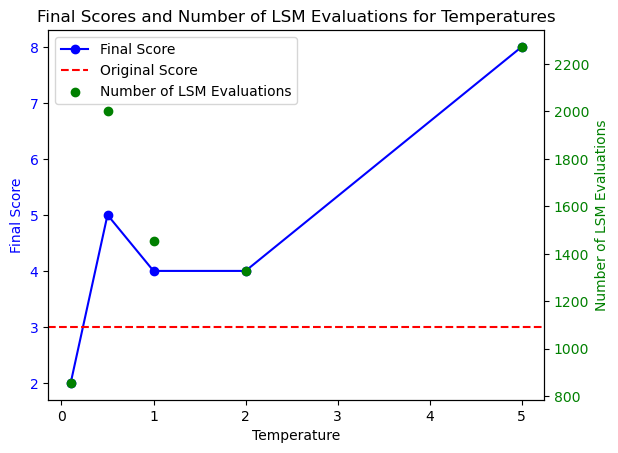

r6r
r3
r5
r7
[<Reaction Random_Rxn_1 at 0x28af3cc10>, <Reaction Random_Rxn_2 at 0x2854204d0>, <Reaction Random_Rxn_3 at 0x28d0d8cd0>, <Reaction Random_Rxn_4 at 0x28e444d50>, <Reaction Random_Rxn_5 at 0x28e444910>, <Reaction Random_Rxn_6 at 0x28e657250>, <Reaction Random_Rxn_7 at 0x2854214d0>, <Reaction Random_Rxn_8 at 0x28e445310>, <Reaction Random_Rxn_9 at 0x28e4be790>, <Reaction Random_Rxn_10 at 0x28e4bc0d0>, <Reaction Random_Rxn_11 at 0x28e4bf510>, <Reaction Random_Rxn_12 at 0x28e4bcd50>, <Reaction Random_Rxn_13 at 0x28e4bd790>, <Reaction Random_Rxn_14 at 0x28e4bd7d0>, <Reaction Random_Rxn_15 at 0x28e4bd590>, <Reaction Random_Rxn_16 at 0x28e4beed0>, <Reaction Random_Rxn_17 at 0x28e4bee90>, <Reaction Random_Rxn_18 at 0x290782390>, <Reaction Random_Rxn_19 at 0x290781790>, <Reaction Random_Rxn_20 at 0x290780290>, <Reaction Random_Rxn_21 at 0x290783010>, <Reaction Random_Rxn_22 at 0x290782690>, <Reaction Random_Rxn_23 at 0x290782a90>, <Reaction Random_Rxn_24 at 0x28cb60ed0>, <Reaction R

[19.51606355029341, 26.534440469144215, 26.534440469144215, 20.30180042747444, 26.534440469144215, 20.30180042747444, 26.534440469144215, 26.534440469144215, 26.534440469144215, 23.148787634322314, 25.070338854007066, 18.853006672199022, 15.593941928634871, 19.51606355029341, 26.534440469144215, 19.988479182250035, 26.534440469144215, 26.534440469144215, 25.070338854007066, 20.880389064630357, 26.534440469144215, 26.534440469144215, 21.448911454677642, 26.534440469144215, 26.534440469144215, 22.43429958221076, 21.788663756311394, 26.534440469144215, 16.510746906913635, 26.534440469144215, 26.534440469144215, 20.880389064630357, 26.534440469144215, 26.534440469144215, 21.88647065348146, 26.534440469144215, 26.534440469144215, 26.534440469144215, 26.534440469144215, 26.534440469144215, 21.788663756062554, 19.51606355029341, 26.534440469144215, 20.301800427473584, 19.988479182250035, 26.534440469144215, 26.534440469144215, 14.44189467830687, 19.516063546048578, 20.880389064630357]
[0.0269

[27.01915369434216, 24.544834738257688, 17.48528143909735, 24.54483472669692, 17.48528143909735, 12.298471046528084, 9.175813321223776, 29.09853512071639, 24.216665341268797, 27.731278977010344, 27.883466646891446, 8.585421989173103, 29.029855228998905, 8.58542202836917, 29.427708858684372, 29.42670921221034, 24.21666534126934, 26.19850204329791, 29.09853511446456, 24.544834738257165, 20.740774074220315, 24.544834738007125, 24.216665327759518, 24.54483473800657, 27.01915369434216, 24.544834738006664, 29.426704513575103, 26.955349658096875, 29.029207233211004, 29.029208835046454, 26.95507095788476, 24.544834738007243, 24.544834738258515, 24.54483473147018, 8.585421989173103, 24.54483473825738, 26.182226856153996, 8.585422028369175, 24.544834738257688, 9.175813321223776, 14.262940595544448, 27.010820421786786, 26.59599949151241]
[0.01670854 0.0183929  0.0258189  0.0183929  0.0258189  0.03670787
 0.04920008 0.01551455 0.01864215 0.01627948 0.01619062 0.05258341
 0.01555126 0.0525834  0.01

[39.80166070371632, 39.80166070371632, 21.90289474904414, 21.902894727231697, 21.90289474904414, 21.902894725341024, 37.6055082810106, 14.647752504198323, 9.754413259557753, 17.485281380967216, 17.485281374400117, 17.48528137646159, 23.591109929115436, 39.80166070371632, 17.4852813775221, 21.902894747514928, 16.311257736990186, 39.80166070371632, 39.80166070371632, 39.80166070371632, 39.80166070371632, 17.48528137476619, 39.80166070371632, 39.80166070371632, 39.80166070371632, 39.80166070371632, 39.80166070371632, 9.175813377031158, 17.485281380967216, 39.80166070371632, 23.59110991591222, 17.48528137646159, 39.80166070371632, 39.80166070371632, 8.926896102237341, 21.83375060279524, 23.591109929115436]
[0.02083258 0.02083258 0.02808296 0.02808296 0.02808296 0.02808296
 0.02143226 0.03434062 0.04208168 0.03143094 0.03143094 0.03143094
 0.02705948 0.02083258 0.03143094 0.02808296 0.03254243 0.02083258
 0.02083258 0.02083258 0.02083258 0.03143094 0.02083258 0.02083258
 0.02083258 0.020832

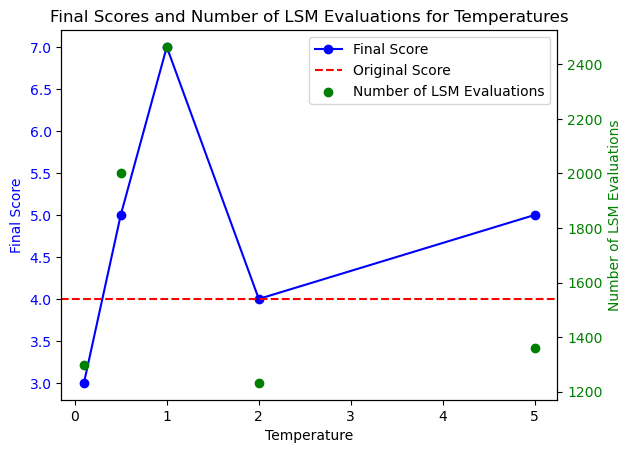

r7
r6r
[<Reaction Random_Rxn_1 at 0x28d075010>, <Reaction Random_Rxn_2 at 0x28d074e90>, <Reaction Random_Rxn_3 at 0x28d22b510>, <Reaction Random_Rxn_4 at 0x28d075f50>, <Reaction Random_Rxn_5 at 0x28e1f0d50>, <Reaction Random_Rxn_6 at 0x28c8180d0>, <Reaction Random_Rxn_7 at 0x28c81b9d0>, <Reaction Random_Rxn_8 at 0x28c4b03d0>, <Reaction Random_Rxn_9 at 0x29077ba90>, <Reaction Random_Rxn_10 at 0x28e1f3950>, <Reaction Random_Rxn_11 at 0x28e4bf690>, <Reaction Random_Rxn_12 at 0x28cc82c10>, <Reaction Random_Rxn_13 at 0x28cc816d0>, <Reaction Random_Rxn_14 at 0x28cc82350>, <Reaction Random_Rxn_15 at 0x28cc81e10>, <Reaction Random_Rxn_16 at 0x28af4f7d0>, <Reaction Random_Rxn_17 at 0x28cc82050>, <Reaction Random_Rxn_18 at 0x28cc83b90>, <Reaction Random_Rxn_19 at 0x28cc83890>, <Reaction Random_Rxn_20 at 0x28e0addd0>, <Reaction Random_Rxn_21 at 0x28cc82e50>, <Reaction Random_Rxn_22 at 0x28e0ad010>, <Reaction Random_Rxn_23 at 0x28cc80a90>, <Reaction Random_Rxn_24 at 0x28e0ae890>, <Reaction Random_

[3.0000001442408446, 3.7071068937971603, 3.707106862409558, 3.0000002090878306, 3.514495867901547, 3.707106903809953, 3.707106856025803, 3.0000002090965303, 3.0000003229356107, 3.000000147396126, 3.7071068629946713, 3.0000001495962327, 3.7071070517649396, 3.0000001683748776, 3.707106875849049, 3.000000146463381, 3.7071069222984203, 3.000000146463381, 3.707106904092922, 3.0000002302287117, 3.0000002090878306, 3.707106875849049, 3.600000079813948, 3.0000001649151375, 3.7071068947355803, 3.7071068550368746, 3.000000288587307, 3.00000045474477, 3.000000146463381, 3.7071068725938243, 3.7071069131134093, 3.0000001596555395, 3.707106903809953, 3.0000001889058714, 3.7071068542861756, 3.7071068995909213, 3.7071069110850896, 3.7071069222984203, 3.0000002063614843, 3.70710694679272, 3.514495945794997, 3.0000002407139235, 3.70710702439129, 3.7071068850316165, 3.0000003664774657, 3.7071069038099536, 3.707106909196077, 3.0000003664774657]
[0.02572729 0.0168487  0.0168487  0.02572728 0.01874608 0.016

[6.000000078203993, 9.277917127461025, 8.292528829365247, 6.000000241800546, 8.042530549222374, 7.7154760975761745, 6.000000092216346, 7.773502757119749, 6.4614203897795655, 6.942810573483711, 8.758890908762101, 9.277916917196242, 6.000000557290557, 9.277916960383402, 6.942809115418674, 9.277916936298261, 6.942809115418674, 8.292528925152496, 6.000000241800546, 9.277916960383402, 6.000000268187929, 6.461420381828002, 6.000000183820779, 9.277916945886364, 8.292531139573043, 6.942809115418674, 3.1547006312145784, 8.292528812831959, 7.773502777910983, 7.7154760975761745, 8.910910179118083, 7.715476129943572, 3.154700667924536, 9.277916936298261, 6.000000352900752, 9.277916943797258, 9.2779170444967, 6.242640774801852, 9.277916956672861, 6.461420362204272, 7.7154760975761745, 6.00000008663861]
[0.02591436 0.02083968 0.0220431  0.02591436 0.02238308 0.02285256
 0.02591436 0.02276711 0.02497194 0.02409065 0.02144824 0.02083968
 0.02591436 0.02083968 0.02409065 0.02083968 0.02409065 0.0220431

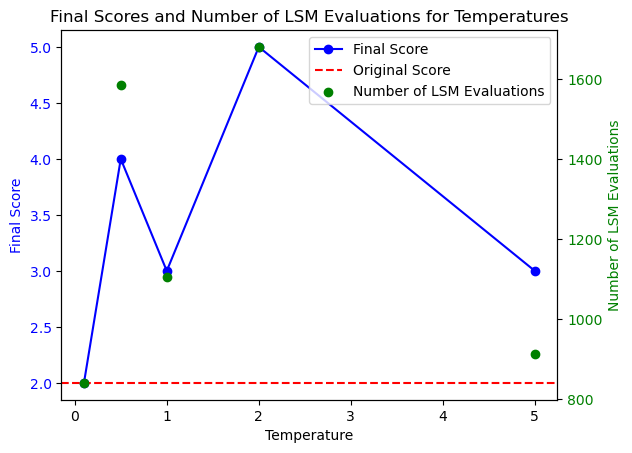

r2
r3
r5
[<Reaction Random_Rxn_1 at 0x290605ad0>, <Reaction Random_Rxn_2 at 0x28e4c2550>, <Reaction Random_Rxn_3 at 0x28e4c0710>, <Reaction Random_Rxn_4 at 0x290653b10>, <Reaction Random_Rxn_5 at 0x28e4c3810>, <Reaction Random_Rxn_6 at 0x28af8d010>, <Reaction Random_Rxn_7 at 0x2906503d0>, <Reaction Random_Rxn_8 at 0x28af8df50>, <Reaction Random_Rxn_9 at 0x28c8c9c90>, <Reaction Random_Rxn_10 at 0x28af8e2d0>, <Reaction Random_Rxn_11 at 0x28af8e4d0>, <Reaction Random_Rxn_12 at 0x28af8e110>, <Reaction Random_Rxn_13 at 0x28c4d8210>, <Reaction Random_Rxn_14 at 0x28ca9df90>, <Reaction Random_Rxn_15 at 0x28ca9fe50>, <Reaction Random_Rxn_16 at 0x28ca9fe10>, <Reaction Random_Rxn_17 at 0x28ca9f690>, <Reaction Random_Rxn_18 at 0x28ca9c5d0>, <Reaction Random_Rxn_19 at 0x28ca9ec90>, <Reaction Random_Rxn_20 at 0x28ca9e790>, <Reaction Random_Rxn_21 at 0x28ca9db10>, <Reaction Random_Rxn_22 at 0x28ca9c110>, <Reaction Random_Rxn_23 at 0x28ca9ff50>, <Reaction Random_Rxn_24 at 0x28ca9ded0>, <Reaction Rando

[7.8637033097914015, 10.440194532315886, 10.440194532315084, 6.609736646799033, 6.6097366468028005, 10.440194532308766, 10.440194527840022, 9.499277844518701, 5.905778917522314, 8.859905776028544, 7.863703309741351, 9.910317600090602, 8.828427129316196, 10.440194532315084, 7.57081009089982, 8.727406623510195, 9.043409184100485, 10.440194532315004, 7.8637033097914015, 10.440194532314795, 8.727406623511307, 5.7932400659625785, 6.449489750643133, 5.905778917522314, 9.499277839912995, 9.49927783865828, 10.440194532309103, 7.570810090957046, 10.440194532311281, 10.440194532315044, 9.499277839914308, 5.793240065963758, 9.910317604631274, 4.000000026655785, 7.863703309706882, 10.44019453231044, 8.727406618727885, 10.440194532310354, 10.440194532310816, 4.956783189400905, 6.4494897589306435, 7.570810090951192, 6.449489750643133, 9.910317604631274, 8.267584714222094, 9.499277839912995, 10.4401945323108, 8.859905776028544, 4.000000013104777]
[0.02070236 0.01559331 0.01559331 0.02462991 0.0246299

[7.8637033097914015, 10.440194532315886, 10.440194532315084, 6.609736646799033, 6.6097366468028005, 10.440194532308766, 10.440194527840022, 9.499277844518701, 5.905778917522314, 8.859905776028544, 7.863703309741351, 9.910317600090602, 8.828427129316196, 10.440194532315084, 8.727406623510195, 9.043409184100485, 10.440194532315004, 7.8637033097914015, 10.440194532314795, 5.7932400659625785, 6.449489750643133, 5.905778917522314, 9.49927783865828, 10.440194532309103, 7.570810090957046, 10.440194532311281, 10.440194532315044, 9.499277839914308, 5.793240065963758, 9.910317604631274, 7.863703309706882, 10.44019453231044, 8.727406618727885, 10.440194532310354, 10.440194532310816, 6.4494897589306435, 7.570810090951192, 6.449489750643133, 9.910317604631274, 8.267584714222094, 9.499277839912995, 10.4401945323108, 4.000000013104777]
[0.02357641 0.02227724 0.02227724 0.02440991 0.02440991 0.02227724
 0.02227724 0.02270204 0.02496592 0.02302063 0.02357641 0.02251052
 0.02303703 0.02227724 0.02309011

[32.000000313080825, 32.000000273447334, 32.00000022042764, 32.00000031308097, 32.000000402860564, 8.000000680418792, 8.000000498961601, 8.000000412633621, 32.000000738968716, 8.00000052778988, 32.00000024931693, 8.000000512363563, 32.0000003622805, 32.00000031308023, 32.00000024967302, 32.0000003130812, 32.00000034547385, 8.000000498961601, 8.000000487777605, 32.00000020486402, 8.000000416527428, 32.000000229356544, 8.000000569607671, 32.000000171478575, 8.000000563186303, 32.000023937115756, 32.000000259383164, 8.00000044374601, 32.0000002852513, 8.000000403145272, 32.00000034547385, 8.000000563186303, 8.000000472461931, 8.000000569607671, 32.00000031308055, 32.000000252159815]
[0.02451424 0.02451424 0.02451424 0.02451424 0.02451424 0.03234673
 0.03234673 0.03234673 0.02451424 0.03234673 0.02451424 0.03234673
 0.02451424 0.02451424 0.02451424 0.02451424 0.02451424 0.03234673
 0.03234673 0.02451424 0.03234673 0.02451424 0.03234673 0.02451424
 0.03234673 0.02451424 0.02451424 0.0323467

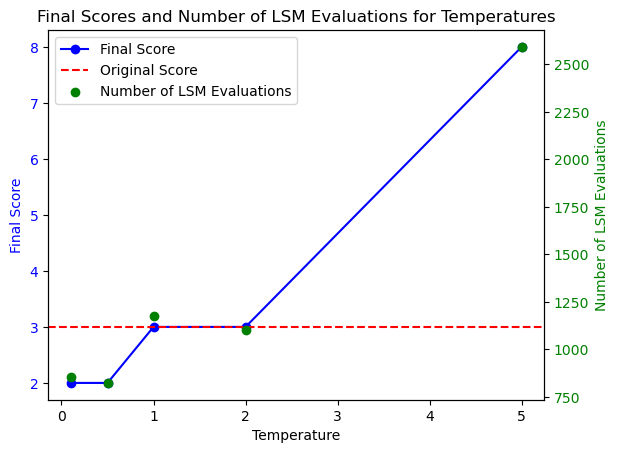

r2
r5
r3
r7
[<Reaction Random_Rxn_1 at 0x285499bd0>, <Reaction Random_Rxn_2 at 0x28d12ccd0>, <Reaction Random_Rxn_3 at 0x28ca9ce90>, <Reaction Random_Rxn_4 at 0x28c745f90>, <Reaction Random_Rxn_5 at 0x29251eb90>, <Reaction Random_Rxn_6 at 0x2906cc0d0>, <Reaction Random_Rxn_7 at 0x2906cd390>, <Reaction Random_Rxn_8 at 0x2906cd7d0>, <Reaction Random_Rxn_9 at 0x2906ce2d0>, <Reaction Random_Rxn_10 at 0x2906ce290>, <Reaction Random_Rxn_11 at 0x2906cc150>, <Reaction Random_Rxn_12 at 0x28af33950>, <Reaction Random_Rxn_13 at 0x2906cc410>, <Reaction Random_Rxn_14 at 0x28e6e8d50>, <Reaction Random_Rxn_15 at 0x28e6e8fd0>, <Reaction Random_Rxn_16 at 0x28e6e8710>, <Reaction Random_Rxn_17 at 0x28e6e9fd0>, <Reaction Random_Rxn_18 at 0x2906cf010>, <Reaction Random_Rxn_19 at 0x2906cc250>, <Reaction Random_Rxn_20 at 0x28c7a0910>, <Reaction Random_Rxn_21 at 0x290657490>, <Reaction Random_Rxn_22 at 0x28e4700d0>, <Reaction Random_Rxn_23 at 0x28e6eb510>, <Reaction Random_Rxn_24 at 0x28e6eb890>, <Reaction Ra

[26.534440469144215, 14.555833735820748, 24.627416997969604, 26.534440469144215, 14.555833736607259, 14.555833735820748, 17.546726569940965, 26.534440469144215, 21.304917927786896, 26.534440469144215, 26.534440469144215, 26.534440469144215, 26.534440469144215, 15.72740661060821, 17.546726569940965, 26.534440469144215, 26.534440469144215, 24.087753562135013, 26.534440469144215, 24.087753562135013, 26.534440469144215, 15.72740661060821, 10.874182955429816, 10.66332759651379, 20.55372394013135, 16.36322315237381, 26.534440469144215, 26.534440469144215, 26.534440469144215, 26.534440469144215, 26.534440469144215, 26.534440469144215, 16.36322315867331, 10.66332759651379, 26.534440469144215, 16.363223158537416, 24.08775356213524, 26.534440469144215, 21.304917927786896, 24.087753562175276, 20.55372394013321, 24.08775356213524, 21.965706476416077, 24.62741699796961, 26.534440469144215, 26.534440469144215, 24.087753562135013, 14.555833740108927, 14.555833739547605, 16.363223158516483]
[0.0106116

[19.118929478227045, 11.229568987920853, 14.761423831650283, 11.229569072351737, 11.229568987920839, 36.298791886939426, 28.816360469102737, 23.47270720903738, 5.032795832801698, 28.8163604691015, 36.298791886939426, 39.49951538040709, 11.22956903161325, 28.92263758105218, 28.816360469102605, 21.79484886883524, 19.118929455190546, 13.997139404128642, 28.891383067853532, 28.81636046910227, 28.816360469103056, 28.81636046910243, 23.472707209037388, 28.816360469102158, 13.997139404128642, 28.81636046910244, 29.437471052564845, 30.347510842059293, 29.75320983927281, 29.015601407877156, 14.761424014870423, 28.000030857150346, 29.303182108149628, 35.30444301547438, 28.816360469102605, 8.276180023413426, 12.48528151715459]
[0.02661819 0.04531886 0.03447576 0.04531886 0.04531886 0.01402006
 0.0176605  0.02168098 0.10111899 0.0176605  0.01402006 0.01288399
 0.04531886 0.0175956  0.0176605  0.02335007 0.02661819 0.03635823
 0.01761464 0.0176605  0.0176605  0.0176605  0.02168098 0.0176605
 0.0363

[29.14213562550391, 46.50194991733425, 47.05300254552469, 47.053002545581954, 47.053002545595675, 47.05300254585055, 14.449111954705787, 45.12289773731552, 46.50194991733425, 29.142135624541954, 26.407094692594026, 35.46669094431927, 35.466690944269565, 45.122897737329936, 45.122897737329936, 29.14213562778278, 25.85604202265861, 16.994022529789724, 26.40709464576989, 47.05300254584781, 46.50194991724583, 40.72844722562994, 45.12289773731552, 46.50194991733425, 26.407094728491916, 14.449111939102382, 44.50809195540457, 14.44911196595653, 14.449111936629484, 26.407094634592553, 16.994022556371235, 29.142135626894333, 45.44249243331848, 35.46669094494748, 45.122897737329936, 29.14213562464592, 21.111763503391046]
[0.02775216 0.02196958 0.02184056 0.02184056 0.02184056 0.02184056
 0.03941276 0.02230278 0.02196958 0.02775216 0.02915393 0.02515632
 0.02515632 0.02230278 0.02230278 0.02775216 0.02946296 0.03634204
 0.02915393 0.02184056 0.02196958 0.02347516 0.02230278 0.02196958
 0.02915393

[5.000000362864133, 17.844571591041305, 17.844570830134295, 8.651483957415758, 17.844570762636614, 10.02963518063469, 14.957819342948898, 17.844571591041305, 5.000000251359492, 19.885813058534723, 6.2909948083606295, 8.162277836099149, 15.233345713218654, 15.233345728190365, 10.519300546971182, 17.844570687495867, 21.006848264210483, 8.162277906489582, 20.731321938705666, 17.844571591041305, 10.519300472392583, 8.1622780228171, 14.957819415391667, 14.95782630945175, 8.162277911031259, 15.233345737288225, 12.071072144310683, 8.162277836099149, 7.886753175633938]
[0.04089425 0.03170699 0.03170699 0.03664698 0.03170699 0.03557945
 0.03284601 0.03170699 0.04089425 0.03102756 0.03905821 0.03707609
 0.03272632 0.03272632 0.03524187 0.03170699 0.03068909 0.03707609
 0.03077024 0.03170699 0.03524187 0.03707609 0.03284601 0.03284601
 0.03707609 0.03272632 0.03428523 0.03707609 0.0373316 ]
27
[6.000000396253256, 6.000000524516974, 6.000000427040156, 6.000000465103996, 6.000000444828686, 6.000000

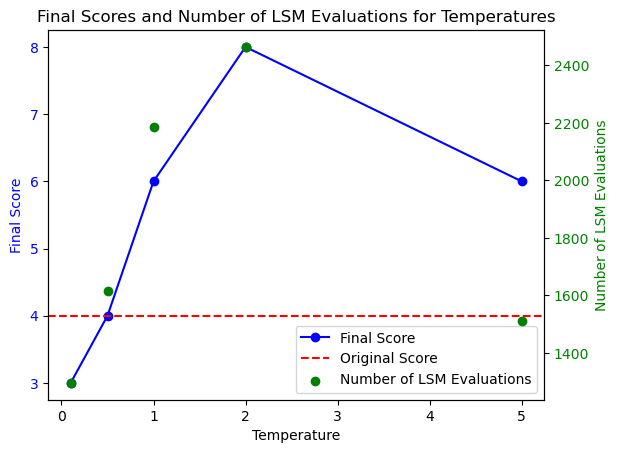

In [26]:
import matplotlib.pyplot as plt

for seed in seeds:
    for num_removed in num_removed_list:
        results = evaluate_model_singular(base_model, num_removed, temperatures, experimental_data, threshold, seed=seed)

        # Extract final scores for the current seed
        final_scores = []
        original_score = None
        num_evals = []
        for temp in temperatures:
            if results[temp]["history"]:  # Ensure history is not empty
                final_scores.append(results[temp]["history"][-1]['final_score'])
                num_evals.append(results[temp]["history"][-1]['num_evals'])
                original_score = results[temp]["original_score"]
            else:
                print(f"Warning: No history for temperature {temp}")
                final_scores.append(None)  # Placeholder for missing data

        # Filter out None values before plotting
        filtered_temperatures = [t for t, score in zip(temperatures, final_scores) if score is not None]
        filtered_scores = [score for score in final_scores if score is not None]
        filtered_num_evals = [evals for evals, score in zip(num_evals, final_scores) if score is not None]

        # Plot final scores for the current seed
        fig, ax1 = plt.subplots()

        # Primary y-axis: Final scores
        ax1.plot(filtered_temperatures, filtered_scores, marker="o", color="b", label="Final Score")
        ax1.set_xlabel("Temperature")
        ax1.set_ylabel("Final Score", color="b")
        ax1.tick_params(axis='y', labelcolor="b")
        ax1.set_title(f"Final Scores and Number of LSM Evaluations for Temperatures")

        # Add original score as a horizontal line
        if original_score:
            ax1.axhline(y=original_score, color='r', linestyle='--', label="Original Score")

        # Secondary y-axis: Number of evaluations
        ax2 = ax1.twinx()
        ax2.scatter(filtered_temperatures, filtered_num_evals, color="g", label="Number of LSM Evaluations")
        ax2.set_ylabel("Number of LSM Evaluations", color="g")
        ax2.tick_params(axis='y', labelcolor="g")

        # Combine legends from both axes
        lines_1, labels_1 = ax1.get_legend_handles_labels()
        lines_2, labels_2 = ax2.get_legend_handles_labels()
        ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="best")

        # Save or display the plot
        plt.savefig(f"final_scores_seed_{num_removed}_{seed}_EV.png")
        plt.show()


Experiment: Removal of different numbers of reactions and reconstruction with different temperature parameters.

In [26]:
# Method to run the workflow for a single model with varying parameters
def evaluate_model(base_model, num_removed_list, temperatures, experimental_data, threshold=3e-7):
    
    results = {}

    for num_removed in num_removed_list:
        for i in range(3):  # Generate three models for each num_removed
            # Create input model and random reaction pool
            original_model = base_model.copy()
            input_model, reaction_list = reduce_model_random(original_model, num_removed)

            for temperature in temperatures:
                print(f"Evaluating num_removed={num_removed}, temperature={temperature}, iteration={i+1}")

                # Run reconstruction
                final_model, history, original_score = reconstruct_model(
                    input_model, original_model, reaction_list, experimental_data, threshold, temperature
                )

                # Save results
                results[(num_removed, temperature, i)] = {
                    "final_model": final_model,
                    "history": history,
                    "original_score": original_score
                }

    return results

In [27]:
num_removed_list = [1, 2, 3, 4]  # Example number of reactions to remove
temperatures = [0.1, 0.5, 1.0, 2.0] 

In [28]:
random.seed(42)
np.random.seed(42)

In [29]:
results42 = evaluate_model(model, num_removed_list, temperatures, experimental_data_zeropadded_out)

R11
Evaluating num_removed=1, temperature=0.1, iteration=1
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=0.5, iteration=1
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=1.0, iteration=1
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=2.0, iteration=1
1.000000070848584
Threshold reached. Reconstruction complete.
R13
Evaluating num_removed=1, temperature=0.1, iteration=2
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=0.5, iteration=2
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=1.0, iteration=2
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=2.0, iteration=2
1.000000070848584
Reaction list is empty. Stopping reconstruction.
R10
Evaluating num_removed=1, temperature=0.1, iter

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Iteration limit reached
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Threshold reached. Reconstruction complete.
Evaluating num_removed=3, temperature=0.5, iteration=3
3.0000002125457526
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in L

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Threshold reached. Reconstruction complete.
Evaluating num_removed=4, temperature=0.5, iteration=1
4.000000283394336
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LS

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

In [30]:
random.seed(17)
np.random.seed(17)

In [31]:
results17 = evaluate_model(model, num_removed_list, temperatures, experimental_data_zeropadded_out)

R9
Evaluating num_removed=1, temperature=0.1, iteration=1
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=0.5, iteration=1
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=1.0, iteration=1
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=2.0, iteration=1
1.000000070848584
Threshold reached. Reconstruction complete.
R7
Evaluating num_removed=1, temperature=0.1, iteration=2
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=0.5, iteration=2
1.000000070848584
Threshold reached. Reconstruction complete.
Evaluating num_removed=1, temperature=1.0, iteration=2
1.000000070848584
Reaction list is empty. Stopping reconstruction.
Evaluating num_removed=1, temperature=2.0, iteration=2
1.000000070848584
Reaction list is empty. Stopping reconstruction.
R7
Evaluating num_removed=1, temperature=0.1, it

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Threshold reached. Reconstruction complete.
Evaluating num_removed=2, temperature=1.0, iteration=1
2.000000141697168
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LS

2.000000141697168
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschl

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Reaction list is empty. Stopping reconstruction.
R6
R7
Evaluating num_removed=2, temperature=0.1, iteration=3
2.000000141697168
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Threshold reached. Reconstruction complete.
Evaluating num_removed=2, temperature=1.0, iteration=3
2.000000141697168
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints 

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

4.000000283394336
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschl

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

/Users/philipp/anaconda3/lib/python3.11/site-packages/scipy/optimize/_optimize.py:404: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Iteration limit reached
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Iteration limit reached
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem


Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular mat

Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Singular matrix C in LSQ subproblem
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality constraints incompatible
Optimierung fehlgeschlagen: Inequality c

In [32]:
results17[(4, 1.0, 2)]["history"]

[{'reaction': 'Random_Rxn_16',
  'final_score': 1.0,
  'fit_score': 0.0,
  'num_evals': 44},
 {'reaction': 'Random_Rxn_1',
  'final_score': 2.0,
  'fit_score': 0.0,
  'num_evals': 77},
 {'reaction': 'Random_Rxn_9',
  'final_score': 3.0,
  'fit_score': 0.0,
  'num_evals': 99}]

In [33]:
results_list = [results42, results17]

In [34]:
import matplotlib.pyplot as plt

In [35]:
def plot_average_num_evals_multiple(results_list, temperatures):
    
    avg_num_evals = {temp: [] for temp in temperatures}

    for results in results_list:
        for (num_removed, temperature, iteration), result in results.items():
            history = result["history"]
            if history:
                avg_num_evals[temperature].append(history[-1]["num_evals"])

    avg_values = {temp: np.mean(avg_num_evals[temp]) for temp in temperatures}

    plt.figure()
    plt.bar(range(len(avg_values)), avg_values.values(), tick_label=[str(temp) for temp in avg_values.keys()])
    plt.xlabel("Temperature")
    plt.ylabel("Average num_evals")
    plt.title("Average num_evals vs. Temperature (Multiple Results)")
    plt.show()


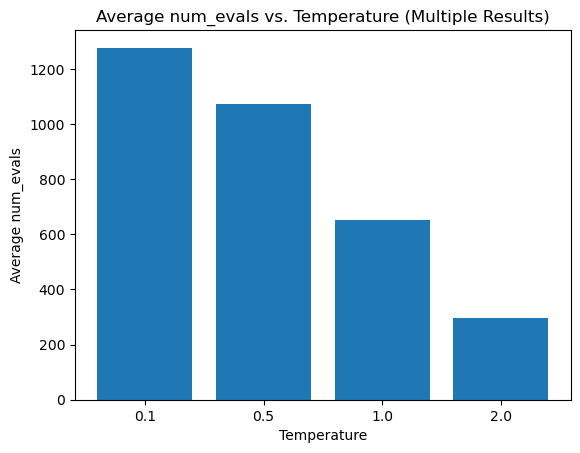

In [36]:
plot_average_num_evals_multiple(results_list, temperatures)

In [37]:
def plot_models_reaching_threshold(results, temperatures, threshold):
    
    models_reaching_threshold = {temp: 0 for temp in temperatures}

    for (num_removed, temperature, iteration), result in results.items():
        history = result["history"]
        if history and history[-1]["fit_score"] < threshold:
            models_reaching_threshold[temperature] += 1

    plt.figure()
    plt.bar(range(len(models_reaching_threshold)), models_reaching_threshold.values(), tick_label=[str(temp) for temp in models_reaching_threshold.keys()])
    plt.xlabel("Temperature")
    plt.ylabel("Number of Models")
    plt.title("Models Reaching Threshold vs. Temperature")
    plt.show()

In [38]:
def plot_models_reaching_threshold_multiple(results_list, temperatures, threshold):
    
    models_reaching_threshold = {temp: 0 for temp in temperatures}

    for results in results_list:
        for (num_removed, temperature, iteration), result in results.items():
            history = result["history"]
            if history and history[-1]["fit_score"] < threshold:
                models_reaching_threshold[temperature] += 1

    plt.figure()
    plt.bar(range(len(models_reaching_threshold)), models_reaching_threshold.values(), tick_label=[str(temp) for temp in models_reaching_threshold.keys()])
    plt.xlabel("Temperature")
    plt.ylabel("Number of Models")
    plt.title("Models Reaching Threshold vs. Temperature (Multiple Results)")
    plt.show()


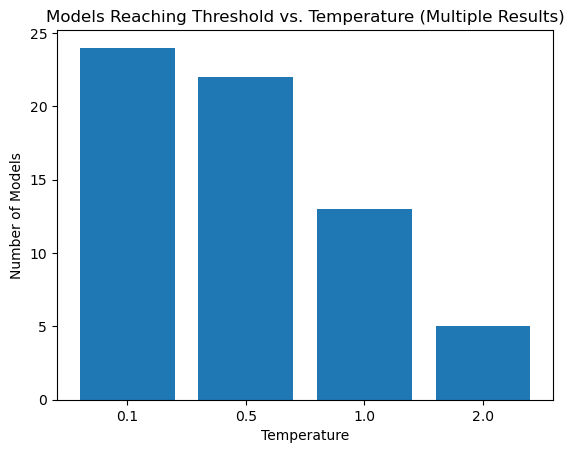

In [39]:
plot_models_reaching_threshold_multiple(results_list, temperatures, threshold)

In [40]:
def plot_final_scores_multiple(results_list, temperatures):
    
    final_scores = {temp: [] for temp in temperatures}

    for results in results_list:
        for (num_removed, temperature, iteration), result in results.items():
            history = result["history"]
            if history:
                final_scores[temperature].append(history[-1]["final_score"])

    plt.figure()
    for temp, scores in final_scores.items():
        plt.scatter([temp] * len(scores), scores, label=f"Temp={temp}")

    plt.xlabel("Temperature")
    plt.ylabel("Final Scores")
    plt.title("Final Scores vs. Temperature")
    plt.legend()
    plt.show()


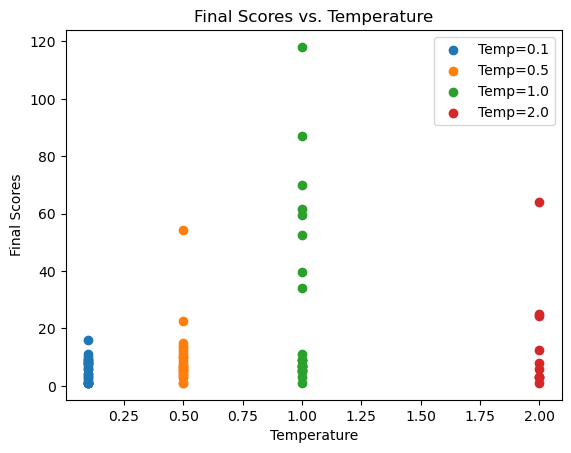

In [41]:
plot_final_scores_multiple(results_list, temperatures)